In [9]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import random
import urllib
import numpy as np
from pathlib import Path
import pandas as pd
from functools import partial
import re
import datetime
import imageio

In [10]:
custom_usernames = [
#                      'localhaven',
#                      'feedtheswimmers',
#                      'smittenkitchen',
#                      'wellandfull',
#                      'themodernproper',
#                      'whatsgabycookin',
#                      'halfbakedharvest',
#                     'jakecohen', #Funny example of following exactly 1% of your followers 99.8K vs 998
#                     'emcdowell',
#                     'cococakeland',
#                     'brianharthoffman',
#                     'pastrywithjenn',
#                     'judy.kim',
#                     'yossyarefi',
#                     'brownedbutterblondie',
#                     'joythebaker',
#                     'thaliaho',
#                     'orlando_jsoto',
#                     'chocolateforbasil',
#                     'theboywhobakes',
#                     'davidthefoodie',
#                     'emcdowell',
#                     'tojo827',
#                     'feedtheswimmers',
                    #'akristofcak',
                    #'sarahcarey1',
                    #'cococakeland',
                    #'evergreenkitchen_',
                    #'ellenmariebennett',
                    #'foodie',
                    #'theeverydayfoodie',
#                     'frommybowl',
#                     'loveandlemons',
#                     'chocolatecoveredkatie',
#                     'panaceas_pantry',
#                     'thefirstmess',
#                     'fooddeco',
#                     'cornerbakeryamsterdam',
#                     'glasgowfoodgeek',
#                     'drizzleanddip',
#                     'cannellevanille',
#                     'gelatomessina', #This one is niche...
#                     'andrewscrivani',
#                     'lemonpiy',
#                     'brandiego',
#                     'citygrit',
#                     'michaelbauer1',
#                     'andrewoknowlton',
#                     'marinagpoloughlin',
#                     'davidlebovitz',   #Mixed bag of images
#                     'ashrod',
#                     'the.xandwich',
#                     'annabarnettcooks',
#                     'ldncheapeats',
#                     'felicityspector',
#                     'infatuation_london',
#                     'ks_ate_here',
#                     'dandoherty_',
#                     'dad_beets',
#                     'food_feels',
#                     'clerkenwellboyec1',
#                     'georgeats',
#                     'howsweeteats',
#                     'izyhossack',
#                     'hemsleyhemsley',
#                     'ottolenghi',
#                     'mynewroots',
#                     'foodintheair',   #company account???
#                     'minimalistbaker',
         
                    
                    
                   ]

In [15]:
class InstagramBot():
    """
    Bot used to scrape information from instagram and perform common features including liking posts
    
    To avoid getting your account banned during troubleshooting, make sure to reinitialize
    your bot with your current browser rather than opening up a new one each time.
    
    
    
    """
    def __init__(self, email, password, browser = None):
        self.browser = webdriver.Chrome() if browser is None else browser
        self.email = email
        self.password = password
        
        
    def signIn(self):
        self.browser.get('https://www.instagram.com/accounts/login/')
        time.sleep(2)
        emailInput = self.browser.find_elements_by_css_selector('form input')[0]
        passwordInput = self.browser.find_elements_by_css_selector('form input')[1]
        
        emailInput.send_keys(self.email)
        passwordInput.send_keys(self.password)
        passwordInput.send_keys(Keys.ENTER)
        time.sleep(2)
        
    def followerList(self, user, max_followers = 1000):
        self.browser.get('https://www.instagram.com/' + user)
        
        time.sleep(20)
        allLinks = self.browser.find_elements_by_css_selector('ul li a')

        followLink = None
        for link in allLinks:
            if link.text.endswith('followers'):
                followLink = link
                break

        followLink.click()
        time.sleep(1)
        followersList = self.browser.find_element_by_css_selector('div[role=\'dialog\'] ul')
        numberFollowersList = len(followersList.find_elements_by_css_selector('li'))
        lastFollowersList = 0
        followersList.find_element_by_css_selector('li').click()

        actionChain = webdriver.ActionChains(self.browser)
        while (numberFollowersList< max_followers and lastFollowersList != numberFollowersList):
            followersList.find_elements_by_css_selector('li')[-1].click()
            lastFollowersList = numberFollowersList
            actionChain.key_down(Keys.SPACE).key_up(Keys.SPACE).perform()
            time.sleep(1)
            numberFollowersList = len(followersList.find_elements_by_css_selector('li'))
            #print(numberFollowersList, lastFollowersList)

        followers = []
        for user in followersList.find_elements_by_css_selector('li'):
            userLink = user.find_element_by_css_selector('a').get_attribute('href')
            followers.append(userLink)
            
        return followers
    
    def goto(self, url):
        self.browser.get(url)
        
        
    def check_private(self):
        return bool(self.browser.find_elements_by_xpath("//*[contains(text(), 'This Account is Private')]"))
    
    
    def check_public(self):
        return not self.check_private()
    
    
    def like_post(self):
        like_button = self.browser.find_elements_by_css_selector('span[aria-label=\'Like\']')
        if bool(like_button): 
            like_button[0].click()
            return True
        else:
            return False
            
    def next_post(self):
        next_button = self.browser.find_elements_by_xpath("//*[contains(text(), 'Next')]")
        if bool(next_button): 
            next_button[0].click()
            return True
        else: return False
        
    def first_post(self):
        first_pic = self.browser.find_elements_by_class_name("_9AhH0")
        if bool(first_pic): 
            first_pic[0].click()
            return True
        else: return False
        
        
    def wait_random(self, low = 1, high = 10):
        wait_time = random.randint(low, high)
        time.sleep(wait_time/10)
        
    def check_action_block(self):
        block_button = self.browser.find_elements_by_xpath("//*[contains(text(), 'This action was blocked')]")
        return bool(block_button)
    
    def reset_activity(self):
        active_button = self.browser.find_elements_by_css_selector('svg[aria-label=\'Activity Feed\']')
        try:
            if bool(active_button): 
                active_button[0].click()
                
                self.wait_random(40,60)
                
                close_activity_button = self.browser.find_elements_by_class_name('_8Mwnh')
                close_activity_button[0].click()
                
                return True
        
            else:
                return False
        except Exception as e:
            print (e)
            return False
        
        
        
    def renavigation_check(self, url):
        if url is not None and not (url == self.browser.current_url): 
            self.browser.get(url)
            time.sleep(1)
        url = self.browser.current_url if url is None else url
        return url


    
    def like_posts_by_user(self, user, num_posts = 3):
        self.browser.get(user)
        try:

            
            self.wait_random(10,30)
            assert self.check_public(), 'Private account'
            self.wait_random(9,15)
            #Check if there is any activity thaqt needs to be cleared (There is a hidden container that prevents clicking)
            if len(self.browser.find_elements_by_class_name("H9zXO")): 
                assert self.reset_activity(), "Problem resetting activity"
                self.wait_random(10, 30)
            assert self.first_post(), 'No first post'
            self.wait_random(15,30)
            assert self.like_post(), 'Already liked'
            self.wait_random(9,20)
            
            for i in range(num_posts-1):
                for _ in range(random.randint(1,3)):
                    assert self.next_post(), 'Last post'
                    self.wait_random(10,40)
                assert self.like_post(), 'Already liked'
                self.wait_random(9,20)
            
            
            actionChain = webdriver.ActionChains(self.browser)
            actionChain.key_down(Keys.ESCAPE).key_up(Keys.ESCAPE).perform()
            
            #self.wait_random(10, 30)
            #assert self.reset_activity(), "Problem resetting activity"
            #self.wait_random(30, 80)
            
        except AssertionError as e:
            print (e)
            if self.check_action_block(): 
                print('Action Blocked!!')
                return 'Block'
            return False
        except Exception as e:
            print('Unknown error', e)
            if self.check_action_block(): 
                print('Action Blocked!!')
                return 'Block'
        finally:
            actionChain = webdriver.ActionChains(self.browser)
            actionChain.key_down(Keys.ESCAPE).key_up(Keys.ESCAPE).perform()
        
        return True
    
    
    """
    Extract a single metric
    """
        
    def get_username(self): return self.browser.find_element_by_class_name("nJAzx").text
        
    def get_likes(self):
        likes_span = self.browser.find_element_by_class_name('Nm9Fw')
        likes = int(likes_span.find_element_by_tag_name('span').text.replace(',', ''))
        return likes
    
    def get_post_time(self): return self.browser.find_element_by_class_name('_1o9PC').get_attribute('datetime')
    
    def get_alt_text(self): return self.browser.find_element_by_class_name('FFVAD').get_attribute('alt')
    
    def get_comment(self, num): 
        try:
            return self.browser.find_elements_by_xpath("//div[@class='C4VMK']/span[@class='']")[num].text
        except:
            return None
    
    def get_tags(self, separator = ' '):
        comment1, comment2 = self.get_comment(0), self.get_comment(1)
        comments = comment1 if comment2 is None else comment1+comment2
        tags = re.findall('#[A-Za-z]+ ', comments)
        return separator.join(tags)
            
        
        

    """
    Extract groups of information found in the same location and return a dict
    """
    
    
    def collect_user_metrics(self, username = None):
        #self.renavigation_check(r'https://www.instagram.com/'+ username)
        if username is not None: 
            self.browser.get(r'https://www.instagram.com/'+ username)
        time.sleep(0.5)
        user_elements = self.browser.find_elements_by_class_name('g47SY')
        num_posts = user_elements[0].text.replace(',', '')
        followers = user_elements[1].get_attribute('title').replace(',', '')
        following = user_elements[2].text.replace(',', '')
        return {'num_posts': num_posts,
               'followers': followers,
               'following': following}
    
    
    def collect_post_metrics(self):
        post_info = {}
        metrics = {'likes': self.get_likes,
                  'posttime': self.get_post_time, 
                  'alt-text': self.get_alt_text,
                  'caption': partial(self.get_comment, 0), 
                  'tags': self.get_tags}
        for feature, value in metrics.items():
            try: post_info[feature] = value()
            except: print("Couldn't collect", feature)
        return post_info
    
    
    
    def scrape_post(self, url = None, include_post = True, include_user = True):
        url = self.renavigation_check(url)
        
        time.sleep(0.1)
        post_info = self.collect_post_metrics() if include_post else {} 
        
        
        time.sleep(0.1)
        user_info = self.collect_user_metrics() if include_user else {}
        
    
        all_info = {**post_info, **user_info}
        return all_info
    
    
   
    """
    Download Posts
    """
    
    def get_post_id(self, url): return url.split(r'/')[-2]
        
    
    
    def download_post(self, url = None, output_dir = None):
        #Option of using the current page, or navigating to a specific url
        output_dir = Path('output') if output_dir is None else output_dir
        output_dir.mkdir(exist_ok=True)
        url = self.renavigation_check(url)
        #time.sleep(2)
            
        try:
            download_link = self.browser.find_elements_by_class_name('FFVAD')[0].get_attribute('src')
            urllib.request.urlretrieve(download_link, output_dir/(url.split(r'/')[-2] + '.jpg'))
        except:
            print('Couldnt print this one: ', url)
            return False
        return True






    """
    """
    
    def fill_in_columns(self, df):
        default = {'str':"", 'num':np.nan}
        columns = [('followers', 'num'), ('following', 'num'),('num_posts', 'num'), ('username', 'str'),
                   ('likes','num'), ('posttime', 'str'), ('alt-text', 'str'), ('caption', 'str'), ('tags', 'str'), 
                   ('Engagement (Avg Likes)', 'num'), ('Downloaded', 'num')]
        for (col, type_of_col) in columns:
            if col not in df.columns: df[col] = default[type_of_col]
        return df

    
    
    def fill_in_dataframe(self, df, starting_position = 0, max_posts = None, include_post = True, include_user = True):
        self.current_dataframe = df
        df = self.fill_in_columns(df)
        for (index, row) in df.iloc[starting_position:,:].iterrows(): 
            print("Current getting index ", index, "Username", df.at[index, 'username'])
            url = df.loc[index,'Links']
            if np.isnan(df.at[index, 'likes']):
                #self.browser.get(url)
                url = self.renavigation_check(url)
                #time.sleep(1)
                #should add something that checks that a row hasn't already been filled
                if not self.browser.find_elements_by_class_name('error-container'):
                    for (key, value) in self.scrape_post(include_post = include_post, include_user = include_user).items():

                            df.at[index, key] = value

                    #time.sleep(1)
                    self.download_post(url)


                    if index%20 == 0: df.to_csv('temp_output.csv')
                #except Exception as e: print(f'Exception: {e} at {url}')


                if max_posts: 
                    if index>max_posts: break
            else:        print('Skipping this post')
            
        return df
    
    
    def export_dataframe(self, output_name = 'output.csv'):
        self.current_dataframe.to_csv(output_name)
        
        
        
    def load_dataframe(self, file_name = 'output.csv'):
        return pd.read_csv(file_name)
    
    
    
    def list_of_posts_from_user(self, max_posts = 1000):
        actionChain = webdriver.ActionChains(self.browser)
        all_links = set()
        old_len = -1
        while old_len!=len(all_links) and old_len<max_posts:
            old_len = len(all_links)
            actionChain.key_down(Keys.END).key_up(Keys.END).perform()
            time.sleep(2)
            links = self.browser.find_elements_by_xpath('//div[@class="v1Nh3 kIKUG  _bz0w"]/a')
            for element in links:
                try:
                    href = element.get_attribute('href')
                    if r'/p/' in href and href not in all_links: all_links.add(href)
                    #print('Got link')
                except Exception as e:
                    print('Exception', e)
                    
        user_post_list = list(all_links)
        return user_post_list
    
    def gather_posts_from_user(self, username, max_posts = 1000):
        """
        Note: this approach find all posts first, then scrapes through them
        An alternate approach involves going to the first post, then gradually iterating through them
        
        """
        self.browser.get(r'https://www.instagram.com/'+ username)
        user_info = self.collect_user_metrics()
        
        post_list = self.list_of_posts_from_user()
        new_df = pd.DataFrame({'Links':post_list, 
                               'filename': [self.get_post_id(url) for url in post_list]})
        for key, value in user_info.items():
            #new_df.assign(key=value)
            new_df[key] = value
            
        new_df['username'] = username
        
        return new_df
    
    def concat_dataframes(self, old, new): return pd.concat([old, new], ignore_index = True, sort = True)
    
    def add_links_to_dataframe_from_user(self, df, username, max_posts = 1000):
        new_df = self.gather_posts_from_user(username, max_posts)
        return self.concat_dataframes(df, new_df)
    
    
    def posts_from_list_of_users(self, user_list, max_posts = 1000, df = None):
        df = pd.DataFrame() if df is None else df
        for user in user_list:
            df = self.add_links_to_dataframe_from_user(df, user, max_posts)
            df.to_csv('temp_user_list.csv')
            
        return df
    
    
    def extract_user_list_from_dataframe(self, df, filters = []):
        mod_df = df
        for (parameter, minimum) in filters:
            mod_df = mod_df[mod_df[parameter]>minimum]
            
        return list(mod_df['username'])
    
    def download_missing(self, df, output_folder = 'Output'):
        if 'Downloaded' not in df.columns: df['Downloaded'] = np.nan
        for (index, row) in df.iterrows():
            post_url = df.at[index, 'Links']
            image_name = self.get_post_id(post_url)
            
            output_folder = Path(output_folder)
            print((output_folder/(image_name+'.jpg')))
            if not np.isnan(df.at[index, 'Downloaded']):
                print('Already processed')
            
            elif (output_folder/(image_name+'.jpg')).exists(): 
                df.at[index, 'Downloaded'] = 1
            else: 
                df.at[index, 'Downloaded'] = 1 if self.download_post(post_url) else 0

                    
            if index%20 == 0: df.to_csv('temp_output.csv')
                
        return df  
    
    
    


In [25]:
"""
General Functions:  These functions are primarily concerned with handling the dataframe that has been assembled
"""
def load_dataframe(file_name = 'output.csv'):
    return pd.read_csv(file_name)


def get_post_id(url): return url.split(r'/')[-2]

def unique_features(df, feature):
    return df[feature].unique()

def avg_likes_per_user(df, user_list):
    avg_likes = {user:None for user in user_list if user is not np.nan}

    for user in user_list:  
        avg_likes[user] = df[df['username']==user] ['likes'].mean()
    return avg_likes
        
    
def engagement_metric_avg_likes(df):
    avg_likes = avg_likes_per_user(df, unique_features(df, 'username'))
    #print(avg_likes)
    if 'engagement_factor_avg_likes' not in df.columns: df['engagement_factor_avg_likes'] = np.nan
    for (index, _) in df.iterrows():
        username = df.at[index, 'username']
        likes = df.at[index, 'likes']
        df.at[index, 'engagement_factor_avg_likes'] = likes/avg_likes[username]
        
    return df


def engagement_factor_rolling_mean(df):
    df['rolling_avg'] = np.nan
    for username in df['username'].unique():
        sorted_df = df[df['username'] == username].sort_values(by = ['posttime'], inplace = False).reset_index()

        window = 20
        num_rows = len(sorted_df)
        if num_rows <window + 2: sorted_df['rolling_avg'] = sorted_df['likes'].mean()
        else:
            sorted_df['rolling_avg'] = sorted_df.rolling(window, min_periods = window-4)['likes'].mean()
            sorted_df['rolling_avg'].loc[0:window-2] = sorted_df.at[window-1,'rolling_avg']
            sorted_df['rolling_avg'].loc[num_rows - window:] = sorted_df.at[num_rows-window -1,'rolling_avg']
        for (index, row) in sorted_df.iterrows():
            #print (username, index, sorted_df.at[index, 'index'], sorted_df.at[index, 'Rolling Avg'])
            df.at[sorted_df.at[index, 'index'], 'rolling_avg'] = sorted_df.at[index, 'rolling_avg']
            
    df['engagement_factor_moving_avg'] = df['likes']/df['rolling_avg']            
    return df

def export_df(df, output_name = 'output_df.csv'):
    df.to_csv(output_name)
    
        
def read_timestamp(timestamp):
        dt = datetime.datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
    
        return  [('date'    , dt.day),
                 ('hour'    , dt.hour),
                 ('minute'  , dt.minute),
                 ('second'  , dt.second),
                 ('month'   , dt.month),
                 ('year'    , dt.year),
                 ('day_name', dt.isoweekday())]
        
def parse_datetimes(df):

    for r in df.itertuples():
        index = r.Index
        timestamp = r.posttime
        if isinstance(timestamp, str) and timestamp:
            parameters = read_timestamp(timestamp)
            for label, value in parameters: df.at[index, label] = value
                
    return df

def create_performance_windows(df, factor, window = 0.1):
    def _inner_window(i):
        if np.isnan(i): return ""
        elif i>1+window: return 'High'
        elif 1+window>=i>=1-window: return 'Normal'
        elif i<1-window: return 'Low'
        else: return 'Unknown'
        
    df['performance'] = [_inner_window(i) for i in df[factor]]
    return df
                


def extract_colour_information(file_str, output_folder = 'Output', ext = '.jpg'):
    folder_path = Path(output_folder)
    filename =  file_str + ext
    if (folder_path/filename).exists():
        img = imageio.imread(folder_path/filename)

        def _inner_calc_range(img, i):
            pct = np.percentile(img[:,:,i], (5,95))
            return pct[1] - pct[0]

        _pct_calc = partial(_inner_calc_range, img)

        colours = ['red','green','blue']
        colour_values = {colour:img[:,:,i].mean() for i, colour in enumerate(colours)}
        colour_values['brightness'] = img.mean()
        hist_values = {colour+'_range': _pct_calc(i) for i, colour in enumerate(colours)}
        hist_values['contrast'] = _pct_calc([range(0,3)])

        colour_values.update(hist_values)
        return colour_values

    else:
        return {}


def fill_in_colour_information(df, output_folder = 'Output'):
    for (index, row) in df.iterrows():
        post_url = df.at[index, 'Links']
        image_name = get_post_id(post_url)

        output_folder = Path(output_folder)
        colour_info = extract_colour_information(image_name, output_folder)
        for param, value in colour_info.items():
            df.at[index, param] = value
    return df



def post_processing_single(df, metric):
    """
    df = engagement_metric_avg_likes(df)
    df = engagement_factor_rolling_mean(df)
    df = parse_datetimes(df)
    df = create_performance_windows(df, 'engagement_factor_moving_avg')
    df = fill_in_colour_information(df)
    """
    df['filename'] = [url.split(r'/')[-2] for url in df['Links']]

    
    df = metric(df)
    
    for name in df.columns:
        if name.startswith('Unnamed'): df.drop(name, axis = 1, inplace = True)
    
    export_df(df, 'Post_Processed.csv')
    
    return df

    
        
def post_processing(df):
    df['filename'] = [url.split(r'/')[-2] for url in df['Links']]

    
    df = engagement_metric_avg_likes(df)
    df = engagement_factor_rolling_mean(df)
    df = parse_datetimes(df)
    df = create_performance_windows(df, 'engagement_factor_moving_avg')
    df = fill_in_colour_information(df)
    
    for name in df.columns:
        if name.startswith('Unnamed'): df.drop(name, axis = 1, inplace = True)
    
    export_df(df, 'Post_Processed.csv')
    
    return df

In [22]:
df = load_dataframe('temp_output.csv')

In [23]:
post_processing(df)

C:\Users\William\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Downloaded,Engagement (Avg Likes),Links,alt-text,caption,followers,following,likes,num_posts,posttime,...,day_name,performance,red,green,blue,brightness,red_range,green_range,blue_range,contrast
0,1.0,NaN,https://www.instagram.com/p/BKo3EVRj5To/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,60.669652,50.508567,40.454009,50.544076,211.0,180.0,157.0,188.0
1,1.0,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,171.191494,141.064033,109.566440,140.607322,209.0,218.0,246.0,237.0
2,1.0,NaN,https://www.instagram.com/p/Belm3PfjAKg/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,171.458558,153.421416,146.528359,157.136111,172.0,178.0,169.0,176.0
3,1.0,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,145.487872,140.031484,135.806149,140.441835,217.0,225.0,236.0,228.0
4,1.0,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,172.488410,165.793399,137.574472,158.618760,206.0,195.0,233.0,223.0
5,1.0,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,167.747052,152.723044,132.703870,151.057989,227.0,228.0,228.0,228.0
6,1.0,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,200.354018,173.255582,158.336429,177.315343,155.0,176.0,203.0,189.0
7,1.0,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,193.134060,184.316282,152.776978,176.742440,201.0,205.0,242.0,226.0
8,1.0,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,192.978900,171.591021,156.104263,173.558061,223.0,236.0,246.0,238.0
9,1.0,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,NaN,NaN,129270,1341,NaN,2584,NaN,...,NaN,,156.756934,143.286964,124.159882,141.401260,200.0,203.0,221.0,212.0


In [28]:
np.select([df['likes']<1000], ['blue'], default = 'black')

array(['black', 'black', 'black', ..., 'black', 'black', 'black'],
      dtype='<U5')

In [7]:
IB = InstagramBot('willcam2500', 'ScrapingTheWeb100')

In [22]:
IB = InstagramBot('webscraper100', 'ScrapingTheWeb100', IB.browser)

# Main Interactions

- IB.load_dataframe(filepath))
- IB.posts_from_list_of_users (username_list)
- IB.download_missing(df)
- IB.fill_in_dataframe(df, include_user, include_post, starting_position = 475)

In [27]:
IB.signIn()

In [28]:
IB.posts_from_list_of_users(custom_usernames, df = IB.load_dataframe('temp_output - Copy (10).csv'))

,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,alt-text,caption,followers,following,likes,num_posts,posttime,tags,username
0,NaN,NaN,https://www.instagram.com/p/BKo3EVRj5To/,0.0,0.0,0.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
1,NaN,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,1.0,1.0,1.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
2,NaN,NaN,https://www.instagram.com/p/Belm3PfjAKg/,2.0,2.0,2.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
3,NaN,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,3.0,3.0,3.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
4,NaN,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,4.0,4.0,4.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
5,NaN,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,5.0,5.0,5.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
6,NaN,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,6.0,6.0,6.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
7,NaN,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,7.0,7.0,7.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
8,NaN,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,8.0,8.0,8.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
9,NaN,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,9.0,9.0,9.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven


In [30]:
IB.fill_in_dataframe(IB.load_dataframe('temp_user_list.csv'), include_user = False, starting_position = 9475)

Current getting index  9475 Username cococakeland
Skipping this post
Current getting index  9476 Username cococakeland
Skipping this post
Current getting index  9477 Username cococakeland
Skipping this post
Current getting index  9478 Username cococakeland
Skipping this post
Current getting index  9479 Username cococakeland
Skipping this post
Current getting index  9480 Username cococakeland
Skipping this post
Current getting index  9481 Username cococakeland
Skipping this post
Current getting index  9482 Username cococakeland
Skipping this post
Current getting index  9483 Username cococakeland
Skipping this post
Current getting index  9484 Username cococakeland
Skipping this post
Current getting index  9485 Username cococakeland
Skipping this post
Current getting index  9486 Username cococakeland
Skipping this post
Current getting index  9487 Username cococakeland
Skipping this post
Current getting index  9488 Username cococakeland
Skipping this post
Current getting index  9489 Userna

Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BfJHMEVB0UH/
Current getting index  9584 Username evergreenkitchen_
Skipping this post
Current getting index  9585 Username evergreenkitchen_
Skipping this post
Current getting index  9586 Username evergreenkitchen_
Skipping this post
Current getting index  9587 Username evergreenkitchen_
Skipping this post
Current getting index  9588 Username evergreenkitchen_
Skipping this post
Current getting index  9589 Username evergreenkitchen_
Skipping this post
Current getting index  9590 Username evergreenkitchen_
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BhmnA9sB-aq/
Current getting index  9591 Username evergreenkitchen_
Skipping this post
Current getting index  9592 Username evergreenkitchen_
Skipping this post
Current getting index  9593 Username evergreenkitchen_
Skipping this post
Current getting index  9594 Username evergreenkit

Current getting index  9685 Username evergreenkitchen_
Current getting index  9686 Username evergreenkitchen_
Current getting index  9687 Username evergreenkitchen_
Current getting index  9688 Username evergreenkitchen_
Current getting index  9689 Username evergreenkitchen_
Current getting index  9690 Username evergreenkitchen_
Current getting index  9691 Username evergreenkitchen_
Current getting index  9692 Username evergreenkitchen_
Current getting index  9693 Username evergreenkitchen_
Current getting index  9694 Username evergreenkitchen_
Current getting index  9695 Username evergreenkitchen_
Current getting index  9696 Username evergreenkitchen_
Current getting index  9697 Username evergreenkitchen_
Current getting index  9698 Username evergreenkitchen_
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/Be05KiyhX7G/
Current getting index  9699 Username evergreenkitchen_
Current getting index  9700 Username evergreenkitchen_
Curre

Current getting index  9816 Username ellenmariebennett
Current getting index  9817 Username ellenmariebennett
Current getting index  9818 Username ellenmariebennett
Current getting index  9819 Username ellenmariebennett
Current getting index  9820 Username ellenmariebennett
Current getting index  9821 Username ellenmariebennett
Current getting index  9822 Username ellenmariebennett
Current getting index  9823 Username ellenmariebennett
Current getting index  9824 Username ellenmariebennett
Current getting index  9825 Username ellenmariebennett
Current getting index  9826 Username ellenmariebennett
Current getting index  9827 Username ellenmariebennett
Current getting index  9828 Username ellenmariebennett
Current getting index  9829 Username ellenmariebennett
Current getting index  9830 Username ellenmariebennett
Current getting index  9831 Username ellenmariebennett
Current getting index  9832 Username ellenmariebennett
Couldn't collect likes
Couldn't collect alt-text
Couldnt print th

Current getting index  9975 Username frommybowl
Current getting index  9976 Username frommybowl
Current getting index  9977 Username frommybowl
Current getting index  9978 Username frommybowl
Current getting index  9979 Username frommybowl
Current getting index  9980 Username frommybowl
Current getting index  9981 Username frommybowl
Current getting index  9982 Username frommybowl
Current getting index  9983 Username frommybowl
Current getting index  9984 Username frommybowl
Current getting index  9985 Username frommybowl
Current getting index  9986 Username frommybowl
Current getting index  9987 Username frommybowl
Current getting index  9988 Username frommybowl
Current getting index  9989 Username frommybowl
Current getting index  9990 Username frommybowl
Current getting index  9991 Username frommybowl
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B39882oiA12/
Current getting index  9992 Username frommybowl
Current getting index

Current getting index  10126 Username loveandlemons
Current getting index  10127 Username loveandlemons
Current getting index  10128 Username loveandlemons
Current getting index  10129 Username loveandlemons
Current getting index  10130 Username loveandlemons
Current getting index  10131 Username loveandlemons
Current getting index  10132 Username loveandlemons
Current getting index  10133 Username loveandlemons
Current getting index  10134 Username loveandlemons
Current getting index  10135 Username loveandlemons
Current getting index  10136 Username loveandlemons
Current getting index  10137 Username loveandlemons
Current getting index  10138 Username loveandlemons
Current getting index  10139 Username loveandlemons
Current getting index  10140 Username loveandlemons
Current getting index  10141 Username loveandlemons
Current getting index  10142 Username loveandlemons
Current getting index  10143 Username loveandlemons
Current getting index  10144 Username loveandlemons
Couldn't col

Current getting index  10270 Username loveandlemons
Current getting index  10271 Username loveandlemons
Current getting index  10272 Username loveandlemons
Current getting index  10273 Username loveandlemons
Current getting index  10274 Username loveandlemons
Current getting index  10275 Username loveandlemons
Current getting index  10276 Username loveandlemons
Current getting index  10277 Username loveandlemons
Current getting index  10278 Username loveandlemons
Current getting index  10279 Username loveandlemons
Current getting index  10280 Username loveandlemons
Current getting index  10281 Username loveandlemons
Current getting index  10282 Username loveandlemons
Current getting index  10283 Username loveandlemons
Current getting index  10284 Username loveandlemons
Current getting index  10285 Username loveandlemons
Current getting index  10286 Username loveandlemons
Current getting index  10287 Username loveandlemons
Current getting index  10288 Username loveandlemons
Current gett

Current getting index  10426 Username loveandlemons
Current getting index  10427 Username loveandlemons
Current getting index  10428 Username loveandlemons
Current getting index  10429 Username loveandlemons
Current getting index  10430 Username loveandlemons
Current getting index  10431 Username loveandlemons
Current getting index  10432 Username loveandlemons
Current getting index  10433 Username loveandlemons
Current getting index  10434 Username loveandlemons
Current getting index  10435 Username loveandlemons
Current getting index  10436 Username loveandlemons
Current getting index  10437 Username loveandlemons
Current getting index  10438 Username loveandlemons
Current getting index  10439 Username loveandlemons
Current getting index  10440 Username loveandlemons
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BvwSFy6jGlG/
Current getting index  10441 Username loveandlemons
Current getting index  10442 Username loveandlemons
C

Current getting index  10582 Username loveandlemons
Current getting index  10583 Username loveandlemons
Current getting index  10584 Username loveandlemons
Current getting index  10585 Username loveandlemons
Current getting index  10586 Username loveandlemons
Current getting index  10587 Username loveandlemons
Current getting index  10588 Username loveandlemons
Current getting index  10589 Username loveandlemons
Current getting index  10590 Username loveandlemons
Current getting index  10591 Username loveandlemons
Current getting index  10592 Username loveandlemons
Current getting index  10593 Username loveandlemons
Current getting index  10594 Username loveandlemons
Current getting index  10595 Username loveandlemons
Current getting index  10596 Username loveandlemons
Current getting index  10597 Username loveandlemons
Current getting index  10598 Username loveandlemons
Current getting index  10599 Username loveandlemons
Current getting index  10600 Username loveandlemons
Current gett

Current getting index  10731 Username loveandlemons
Current getting index  10732 Username loveandlemons
Current getting index  10733 Username loveandlemons
Current getting index  10734 Username loveandlemons
Current getting index  10735 Username loveandlemons
Current getting index  10736 Username loveandlemons
Current getting index  10737 Username loveandlemons
Current getting index  10738 Username loveandlemons
Current getting index  10739 Username loveandlemons
Current getting index  10740 Username loveandlemons
Current getting index  10741 Username loveandlemons
Current getting index  10742 Username loveandlemons
Current getting index  10743 Username loveandlemons
Current getting index  10744 Username loveandlemons
Current getting index  10745 Username loveandlemons
Current getting index  10746 Username loveandlemons
Current getting index  10747 Username loveandlemons
Current getting index  10748 Username loveandlemons
Current getting index  10749 Username loveandlemons
Current gett

Current getting index  10882 Username loveandlemons
Current getting index  10883 Username loveandlemons
Current getting index  10884 Username loveandlemons
Current getting index  10885 Username loveandlemons
Current getting index  10886 Username loveandlemons
Current getting index  10887 Username loveandlemons
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BNc8xvmgwXJ/
Current getting index  10888 Username loveandlemons
Current getting index  10889 Username loveandlemons
Current getting index  10890 Username loveandlemons
Current getting index  10891 Username loveandlemons
Current getting index  10892 Username loveandlemons
Current getting index  10893 Username loveandlemons
Current getting index  10894 Username loveandlemons
Current getting index  10895 Username loveandlemons
Current getting index  10896 Username loveandlemons
Current getting index  10897 Username loveandlemons
Current getting index  10898 Username loveandlemons
C

Current getting index  11031 Username loveandlemons
Current getting index  11032 Username loveandlemons
Current getting index  11033 Username loveandlemons
Current getting index  11034 Username loveandlemons
Current getting index  11035 Username loveandlemons
Current getting index  11036 Username loveandlemons
Current getting index  11037 Username loveandlemons
Current getting index  11038 Username loveandlemons
Current getting index  11039 Username loveandlemons
Current getting index  11040 Username loveandlemons
Current getting index  11041 Username loveandlemons
Current getting index  11042 Username loveandlemons
Current getting index  11043 Username loveandlemons
Current getting index  11044 Username loveandlemons
Current getting index  11045 Username loveandlemons
Current getting index  11046 Username loveandlemons
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BYjkeRIgYqc/
Current getting index  11047 Username loveandlemons
C

Current getting index  11171 Username chocolatecoveredkatie
Current getting index  11172 Username chocolatecoveredkatie
Current getting index  11173 Username chocolatecoveredkatie
Current getting index  11174 Username chocolatecoveredkatie
Current getting index  11175 Username chocolatecoveredkatie
Current getting index  11176 Username chocolatecoveredkatie
Current getting index  11177 Username chocolatecoveredkatie
Current getting index  11178 Username chocolatecoveredkatie
Current getting index  11179 Username chocolatecoveredkatie
Current getting index  11180 Username chocolatecoveredkatie
Current getting index  11181 Username chocolatecoveredkatie
Current getting index  11182 Username chocolatecoveredkatie
Current getting index  11183 Username chocolatecoveredkatie
Current getting index  11184 Username chocolatecoveredkatie
Current getting index  11185 Username chocolatecoveredkatie
Current getting index  11186 Username chocolatecoveredkatie
Current getting index  11187 Username ch

Current getting index  11304 Username chocolatecoveredkatie
Current getting index  11305 Username chocolatecoveredkatie
Current getting index  11306 Username chocolatecoveredkatie
Current getting index  11307 Username chocolatecoveredkatie
Current getting index  11308 Username chocolatecoveredkatie
Current getting index  11309 Username chocolatecoveredkatie
Current getting index  11310 Username chocolatecoveredkatie
Current getting index  11311 Username chocolatecoveredkatie
Current getting index  11312 Username chocolatecoveredkatie
Current getting index  11313 Username chocolatecoveredkatie
Current getting index  11314 Username chocolatecoveredkatie
Current getting index  11315 Username chocolatecoveredkatie
Current getting index  11316 Username chocolatecoveredkatie
Current getting index  11317 Username chocolatecoveredkatie
Current getting index  11318 Username chocolatecoveredkatie
Current getting index  11319 Username chocolatecoveredkatie
Current getting index  11320 Username ch

Current getting index  11437 Username chocolatecoveredkatie
Current getting index  11438 Username chocolatecoveredkatie
Current getting index  11439 Username chocolatecoveredkatie
Current getting index  11440 Username chocolatecoveredkatie
Current getting index  11441 Username chocolatecoveredkatie
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B6ybqVJgnzQ/
Current getting index  11442 Username chocolatecoveredkatie
Current getting index  11443 Username chocolatecoveredkatie
Current getting index  11444 Username chocolatecoveredkatie
Current getting index  11445 Username chocolatecoveredkatie
Current getting index  11446 Username chocolatecoveredkatie
Current getting index  11447 Username chocolatecoveredkatie
Current getting index  11448 Username chocolatecoveredkatie
Current getting index  11449 Username chocolatecoveredkatie
Current getting index  11450 Username chocolatecoveredkatie
Current getting index  11451 Username chocola

Current getting index  11566 Username chocolatecoveredkatie
Current getting index  11567 Username panaceas_pantry
Current getting index  11568 Username panaceas_pantry
Current getting index  11569 Username panaceas_pantry
Current getting index  11570 Username panaceas_pantry
Current getting index  11571 Username panaceas_pantry
Current getting index  11572 Username panaceas_pantry
Current getting index  11573 Username panaceas_pantry
Current getting index  11574 Username panaceas_pantry
Current getting index  11575 Username panaceas_pantry
Current getting index  11576 Username panaceas_pantry
Current getting index  11577 Username panaceas_pantry
Current getting index  11578 Username panaceas_pantry
Current getting index  11579 Username panaceas_pantry
Current getting index  11580 Username panaceas_pantry
Current getting index  11581 Username panaceas_pantry
Current getting index  11582 Username panaceas_pantry
Current getting index  11583 Username panaceas_pantry
Current getting index 

Current getting index  11718 Username panaceas_pantry
Current getting index  11719 Username panaceas_pantry
Current getting index  11720 Username panaceas_pantry
Current getting index  11721 Username panaceas_pantry
Current getting index  11722 Username panaceas_pantry
Current getting index  11723 Username panaceas_pantry
Current getting index  11724 Username panaceas_pantry
Current getting index  11725 Username panaceas_pantry
Current getting index  11726 Username panaceas_pantry
Current getting index  11727 Username panaceas_pantry
Current getting index  11728 Username panaceas_pantry
Current getting index  11729 Username panaceas_pantry
Current getting index  11730 Username panaceas_pantry
Current getting index  11731 Username panaceas_pantry
Current getting index  11732 Username panaceas_pantry
Current getting index  11733 Username panaceas_pantry
Current getting index  11734 Username panaceas_pantry
Current getting index  11735 Username panaceas_pantry
Current getting index  11736

Current getting index  11870 Username panaceas_pantry
Current getting index  11871 Username panaceas_pantry
Current getting index  11872 Username panaceas_pantry
Current getting index  11873 Username panaceas_pantry
Current getting index  11874 Username panaceas_pantry
Current getting index  11875 Username panaceas_pantry
Current getting index  11876 Username panaceas_pantry
Current getting index  11877 Username panaceas_pantry
Current getting index  11878 Username panaceas_pantry
Current getting index  11879 Username panaceas_pantry
Current getting index  11880 Username panaceas_pantry
Current getting index  11881 Username panaceas_pantry
Current getting index  11882 Username panaceas_pantry
Current getting index  11883 Username panaceas_pantry
Current getting index  11884 Username panaceas_pantry
Current getting index  11885 Username panaceas_pantry
Current getting index  11886 Username panaceas_pantry
Current getting index  11887 Username panaceas_pantry
Current getting index  11888

Current getting index  12022 Username panaceas_pantry
Current getting index  12023 Username panaceas_pantry
Current getting index  12024 Username panaceas_pantry
Current getting index  12025 Username panaceas_pantry
Current getting index  12026 Username panaceas_pantry
Current getting index  12027 Username panaceas_pantry
Current getting index  12028 Username panaceas_pantry
Current getting index  12029 Username panaceas_pantry
Current getting index  12030 Username panaceas_pantry
Current getting index  12031 Username panaceas_pantry
Current getting index  12032 Username panaceas_pantry
Current getting index  12033 Username panaceas_pantry
Current getting index  12034 Username panaceas_pantry
Current getting index  12035 Username panaceas_pantry
Current getting index  12036 Username panaceas_pantry
Current getting index  12037 Username panaceas_pantry
Current getting index  12038 Username panaceas_pantry
Current getting index  12039 Username panaceas_pantry
Current getting index  12040

Current getting index  12174 Username panaceas_pantry
Current getting index  12175 Username panaceas_pantry
Current getting index  12176 Username panaceas_pantry
Current getting index  12177 Username panaceas_pantry
Current getting index  12178 Username panaceas_pantry
Current getting index  12179 Username panaceas_pantry
Current getting index  12180 Username panaceas_pantry
Current getting index  12181 Username panaceas_pantry
Current getting index  12182 Username panaceas_pantry
Current getting index  12183 Username panaceas_pantry
Current getting index  12184 Username panaceas_pantry
Current getting index  12185 Username panaceas_pantry
Current getting index  12186 Username panaceas_pantry
Current getting index  12187 Username panaceas_pantry
Current getting index  12188 Username panaceas_pantry
Current getting index  12189 Username panaceas_pantry
Current getting index  12190 Username panaceas_pantry
Current getting index  12191 Username panaceas_pantry
Current getting index  12192

Current getting index  12326 Username panaceas_pantry
Current getting index  12327 Username panaceas_pantry
Current getting index  12328 Username panaceas_pantry
Current getting index  12329 Username panaceas_pantry
Current getting index  12330 Username panaceas_pantry
Current getting index  12331 Username panaceas_pantry
Current getting index  12332 Username panaceas_pantry
Current getting index  12333 Username panaceas_pantry
Current getting index  12334 Username panaceas_pantry
Current getting index  12335 Username thefirstmess
Current getting index  12336 Username thefirstmess
Current getting index  12337 Username thefirstmess
Current getting index  12338 Username thefirstmess
Current getting index  12339 Username thefirstmess
Current getting index  12340 Username thefirstmess
Current getting index  12341 Username thefirstmess
Current getting index  12342 Username thefirstmess
Current getting index  12343 Username thefirstmess
Current getting index  12344 Username thefirstmess
Curr

Current getting index  12481 Username citygrit
Current getting index  12482 Username citygrit
Current getting index  12483 Username citygrit
Current getting index  12484 Username citygrit
Current getting index  12485 Username citygrit
Current getting index  12486 Username citygrit
Current getting index  12487 Username citygrit
Current getting index  12488 Username citygrit
Current getting index  12489 Username citygrit
Current getting index  12490 Username citygrit
Current getting index  12491 Username michaelbauer1
Current getting index  12492 Username michaelbauer1
Current getting index  12493 Username michaelbauer1
Current getting index  12494 Username michaelbauer1
Current getting index  12495 Username michaelbauer1
Current getting index  12496 Username michaelbauer1
Current getting index  12497 Username michaelbauer1
Current getting index  12498 Username michaelbauer1
Current getting index  12499 Username michaelbauer1
Current getting index  12500 Username michaelbauer1
Current ge

Current getting index  12629 Username ks_ate_here
Current getting index  12630 Username ks_ate_here
Current getting index  12631 Username ks_ate_here
Current getting index  12632 Username ks_ate_here
Current getting index  12633 Username ks_ate_here
Current getting index  12634 Username ks_ate_here
Current getting index  12635 Username dandoherty_
Current getting index  12636 Username dandoherty_
Current getting index  12637 Username dandoherty_
Current getting index  12638 Username dandoherty_
Current getting index  12639 Username dandoherty_
Current getting index  12640 Username dandoherty_
Current getting index  12641 Username dandoherty_
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BnGaLg2nuUl/
Current getting index  12642 Username dandoherty_
Current getting index  12643 Username dandoherty_
Current getting index  12644 Username dandoherty_
Current getting index  12645 Username dandoherty_
Current getting index  12646 Userna

Current getting index  12785 Username food_feels
Current getting index  12786 Username food_feels
Current getting index  12787 Username food_feels
Current getting index  12788 Username food_feels
Current getting index  12789 Username food_feels
Current getting index  12790 Username food_feels
Current getting index  12791 Username clerkenwellboyec1
Current getting index  12792 Username clerkenwellboyec1
Current getting index  12793 Username clerkenwellboyec1
Current getting index  12794 Username clerkenwellboyec1
Current getting index  12795 Username clerkenwellboyec1
Current getting index  12796 Username clerkenwellboyec1
Current getting index  12797 Username clerkenwellboyec1
Current getting index  12798 Username clerkenwellboyec1
Current getting index  12799 Username clerkenwellboyec1
Current getting index  12800 Username clerkenwellboyec1
Current getting index  12801 Username clerkenwellboyec1
Current getting index  12802 Username clerkenwellboyec1
Current getting index  12803 Usern

Current getting index  12920 Username izyhossack
Current getting index  12921 Username izyhossack
Current getting index  12922 Username izyhossack
Current getting index  12923 Username izyhossack
Current getting index  12924 Username izyhossack
Current getting index  12925 Username izyhossack
Current getting index  12926 Username izyhossack
Current getting index  12927 Username izyhossack
Current getting index  12928 Username izyhossack
Current getting index  12929 Username izyhossack
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/Bl8d8riFnfY/
Current getting index  12930 Username izyhossack
Current getting index  12931 Username izyhossack
Current getting index  12932 Username izyhossack
Current getting index  12933 Username izyhossack
Current getting index  12934 Username izyhossack
Current getting index  12935 Username izyhossack
Current getting index  12936 Username izyhossack
Current getting index  12937 Username izyhossack
Cur

Current getting index  13069 Username izyhossack
Current getting index  13070 Username izyhossack
Current getting index  13071 Username izyhossack
Current getting index  13072 Username izyhossack
Current getting index  13073 Username izyhossack
Current getting index  13074 Username izyhossack
Current getting index  13075 Username izyhossack
Current getting index  13076 Username izyhossack
Current getting index  13077 Username izyhossack
Current getting index  13078 Username izyhossack
Current getting index  13079 Username izyhossack
Current getting index  13080 Username izyhossack
Current getting index  13081 Username izyhossack
Current getting index  13082 Username izyhossack
Current getting index  13083 Username izyhossack
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BWc1kyanAgJ/
Current getting index  13084 Username izyhossack
Current getting index  13085 Username izyhossack
Current getting index  13086 Username izyhossack
Cur

Current getting index  13210 Username hemsleyhemsley
Current getting index  13211 Username hemsleyhemsley
Current getting index  13212 Username hemsleyhemsley
Current getting index  13213 Username hemsleyhemsley
Current getting index  13214 Username hemsleyhemsley
Current getting index  13215 Username hemsleyhemsley
Current getting index  13216 Username hemsleyhemsley
Current getting index  13217 Username hemsleyhemsley
Current getting index  13218 Username hemsleyhemsley
Current getting index  13219 Username hemsleyhemsley
Current getting index  13220 Username hemsleyhemsley
Current getting index  13221 Username hemsleyhemsley
Current getting index  13222 Username hemsleyhemsley
Current getting index  13223 Username hemsleyhemsley
Current getting index  13224 Username hemsleyhemsley
Current getting index  13225 Username hemsleyhemsley
Current getting index  13226 Username hemsleyhemsley
Current getting index  13227 Username hemsleyhemsley
Current getting index  13228 Username hemsleyh

Couldnt print this one:  https://www.instagram.com/p/Bqk0a0oH_5w/
Current getting index  13351 Username hemsleyhemsley
Current getting index  13352 Username hemsleyhemsley
Current getting index  13353 Username hemsleyhemsley
Current getting index  13354 Username hemsleyhemsley
Current getting index  13355 Username hemsleyhemsley
Current getting index  13356 Username hemsleyhemsley
Current getting index  13357 Username hemsleyhemsley
Current getting index  13358 Username hemsleyhemsley
Current getting index  13359 Username hemsleyhemsley
Current getting index  13360 Username hemsleyhemsley
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BwZSyIInxSy/
Current getting index  13361 Username hemsleyhemsley
Current getting index  13362 Username hemsleyhemsley
Current getting index  13363 Username hemsleyhemsley
Current getting index  13364 Username hemsleyhemsley
Current getting index  13365 Username hemsleyhemsley
Current getting index  1

Current getting index  13479 Username ottolenghi
Current getting index  13480 Username ottolenghi
Current getting index  13481 Username ottolenghi
Current getting index  13482 Username ottolenghi
Current getting index  13483 Username ottolenghi
Current getting index  13484 Username ottolenghi
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B1sYdkqHdvZ/
Current getting index  13485 Username ottolenghi
Current getting index  13486 Username ottolenghi
Current getting index  13487 Username ottolenghi
Current getting index  13488 Username ottolenghi
Current getting index  13489 Username ottolenghi
Current getting index  13490 Username ottolenghi
Current getting index  13491 Username ottolenghi
Current getting index  13492 Username ottolenghi
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B4z_jklH6nI/
Current getting index  13493 Username ottolenghi
Current getting index  13494 Userna

Current getting index  13626 Username ottolenghi
Current getting index  13627 Username ottolenghi
Current getting index  13628 Username ottolenghi
Current getting index  13629 Username ottolenghi
Current getting index  13630 Username ottolenghi
Current getting index  13631 Username ottolenghi
Current getting index  13632 Username ottolenghi
Current getting index  13633 Username ottolenghi
Current getting index  13634 Username ottolenghi
Current getting index  13635 Username ottolenghi
Current getting index  13636 Username ottolenghi
Current getting index  13637 Username ottolenghi
Current getting index  13638 Username ottolenghi
Current getting index  13639 Username ottolenghi
Current getting index  13640 Username ottolenghi
Current getting index  13641 Username ottolenghi
Current getting index  13642 Username ottolenghi
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B6Au6VFng9b/
Current getting index  13643 Username ottolenghi
Cou

Current getting index  13787 Username mynewroots
Current getting index  13788 Username mynewroots
Current getting index  13789 Username mynewroots
Current getting index  13790 Username mynewroots
Current getting index  13791 Username mynewroots
Current getting index  13792 Username mynewroots
Current getting index  13793 Username mynewroots
Current getting index  13794 Username mynewroots
Current getting index  13795 Username mynewroots
Current getting index  13796 Username mynewroots
Current getting index  13797 Username mynewroots
Current getting index  13798 Username mynewroots
Current getting index  13799 Username mynewroots
Current getting index  13800 Username mynewroots
Current getting index  13801 Username mynewroots
Current getting index  13802 Username mynewroots
Current getting index  13803 Username mynewroots
Current getting index  13804 Username mynewroots
Current getting index  13805 Username mynewroots
Current getting index  13806 Username mynewroots
Current getting inde

Current getting index  13952 Username mynewroots
Current getting index  13953 Username mynewroots
Current getting index  13954 Username mynewroots
Current getting index  13955 Username mynewroots
Current getting index  13956 Username mynewroots
Current getting index  13957 Username mynewroots
Current getting index  13958 Username mynewroots
Current getting index  13959 Username mynewroots
Current getting index  13960 Username mynewroots
Current getting index  13961 Username mynewroots
Current getting index  13962 Username mynewroots
Current getting index  13963 Username mynewroots
Current getting index  13964 Username mynewroots
Current getting index  13965 Username mynewroots
Current getting index  13966 Username mynewroots
Current getting index  13967 Username mynewroots
Current getting index  13968 Username mynewroots
Current getting index  13969 Username mynewroots
Current getting index  13970 Username mynewroots
Current getting index  13971 Username mynewroots
Current getting inde

Current getting index  14117 Username foodintheair
Current getting index  14118 Username foodintheair
Current getting index  14119 Username foodintheair
Current getting index  14120 Username foodintheair
Current getting index  14121 Username foodintheair
Current getting index  14122 Username foodintheair
Current getting index  14123 Username foodintheair
Current getting index  14124 Username foodintheair
Current getting index  14125 Username foodintheair
Current getting index  14126 Username foodintheair
Current getting index  14127 Username foodintheair
Current getting index  14128 Username foodintheair
Current getting index  14129 Username foodintheair
Current getting index  14130 Username foodintheair
Current getting index  14131 Username foodintheair
Current getting index  14132 Username foodintheair
Current getting index  14133 Username foodintheair
Current getting index  14134 Username foodintheair
Current getting index  14135 Username foodintheair
Current getting index  14136 Us

Current getting index  14278 Username foodintheair
Current getting index  14279 Username foodintheair
Current getting index  14280 Username foodintheair
Current getting index  14281 Username foodintheair
Current getting index  14282 Username foodintheair
Current getting index  14283 Username foodintheair
Current getting index  14284 Username foodintheair
Current getting index  14285 Username foodintheair
Current getting index  14286 Username foodintheair
Current getting index  14287 Username foodintheair
Current getting index  14288 Username foodintheair
Current getting index  14289 Username foodintheair
Current getting index  14290 Username foodintheair
Current getting index  14291 Username foodintheair
Current getting index  14292 Username foodintheair
Current getting index  14293 Username foodintheair
Current getting index  14294 Username foodintheair
Current getting index  14295 Username foodintheair
Current getting index  14296 Username foodintheair
Current getting index  14297 Us

Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/Bzx-6VIhX-F/
Current getting index  14397 Username minimalistbaker
Current getting index  14398 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B3cye2MBubg/
Current getting index  14399 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B63FhGWBEfC/
Current getting index  14400 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B3u4IAeBJ2P/
Current getting index  14401 Username minimalistbaker
Current getting index  14402 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B1PSA-tBLE8/
Current getting index  14403 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-tex

Couldnt print this one:  https://www.instagram.com/p/B26nZ0VghA0/
Current getting index  14467 Username minimalistbaker
Current getting index  14468 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B1dyRBVB7NP/
Current getting index  14469 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B0oKN4sBypS/
Current getting index  14470 Username minimalistbaker
Current getting index  14471 Username minimalistbaker
Current getting index  14472 Username minimalistbaker
Current getting index  14473 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B0Yg8o7B0RB/
Current getting index  14474 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B3heKRXh3lY/
Current getting index  14475 Username mini

Current getting index  14541 Username minimalistbaker
Current getting index  14542 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B2y_KM0g2c6/
Current getting index  14543 Username minimalistbaker
Current getting index  14544 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B1M7lQ2hTt8/
Current getting index  14545 Username minimalistbaker
Current getting index  14546 Username minimalistbaker
Current getting index  14547 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B35JU80hKJZ/
Current getting index  14548 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B2el5IkAbBj/
Current getting index  14549 Username minimalistbaker
Current getting index  14550 Username minimalistbaker


Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B1lvK6kBaJa/
Current getting index  14617 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B4PlW1jBa0q/
Current getting index  14618 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/BzDlnHhBjTE/
Current getting index  14619 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B5fsMpthk3z/
Current getting index  14620 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B576gVgh1qr/
Current getting index  14621 Username minimalistbaker
Couldn't collect likes
Couldn't collect alt-text
Couldnt print this one:  https://www.instagram.com/p/B0jvKDIg8j5/
Current getting index  14622 Username mi

,Unnamed: 0,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,alt-text,caption,followers,following,likes,num_posts,posttime,tags,username
0,0,NaN,NaN,https://www.instagram.com/p/BKo3EVRj5To/,0.0,0.0,0.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
1,1,NaN,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,1.0,1.0,1.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
2,2,NaN,NaN,https://www.instagram.com/p/Belm3PfjAKg/,2.0,2.0,2.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
3,3,NaN,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,3.0,3.0,3.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
4,4,NaN,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,4.0,4.0,4.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
5,5,NaN,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,5.0,5.0,5.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
6,6,NaN,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,6.0,6.0,6.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
7,7,NaN,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,7.0,7.0,7.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
8,8,NaN,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,8.0,8.0,8.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
9,9,NaN,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,9.0,9.0,9.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven


In [ ]:
IB.download_missing(IB.load_dataframe('temp_output - Copy (11).csv'))

Output\BKo3EVRj5To.jpg
Output\B5xuUqpBZPb.jpg
Output\Belm3PfjAKg.jpg
Output\BQnfW-ujX6q.jpg
Output\BpaZqwmgOVT.jpg
Output\BbFvUb2D_zk.jpg
Output\Bjr4i_Yh4Tj.jpg
Output\BSZIDk1D0AS.jpg
Output\BNUmiXzjVuV.jpg
Output\BzdbrZ3BBqn.jpg
Output\B6rIiJMBNuK.jpg
Output\BuR4MIuB_1i.jpg
Output\BgMKji2DXPe.jpg
Output\Bc_EitTjWl5.jpg
Output\BTWasLfDfN4.jpg
Output\BgZjPARDuU2.jpg
Output\BoMRXU_jP8P.jpg
Output\BYGy6N4D1qv.jpg
Output\BZqxv3PjW69.jpg
Output\BR9bfdkDe78.jpg
Output\B3iFSRxhNkz.jpg
Output\BLL91yIjgLx.jpg
Output\BaruZlAD3OV.jpg
Output\BYYtNwODZZT.jpg
Output\BorLnpsDS_y.jpg
Output\Bzy-tktBCSQ.jpg
Output\BZjVzbkjxKF.jpg
Output\BMmnBNDjQnN.jpg
Output\B4dXlWqhyxe.jpg
Output\BcgaS-_DWP9.jpg
Output\B2fKmg5hNjw.jpg
Output\BfbA477j9iU.jpg
Output\BcmwDqbDQCS.jpg
Output\BoWwPB4j_PO.jpg
Output\BbzWdzJDjl6.jpg
Output\BnyqMjMDFLi.jpg
Output\Be85PgBjYqQ.jpg
Output\BYloOdLD1OY.jpg
Output\Bnq8Fq8jc1Q.jpg
Output\Bbe7j72jpUt.jpg
Output\BXjphDMjr2h.jpg
Output\BUbAzG7j8YC.jpg
Output\BLjaTxIDuzy.jpg
Output\BvwZ

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\William\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse(buffering=True)
TypeError: getresponse() got an unexpected keyword argument 'buffering'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\William\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-163-c816a22c0355>", line 1, in <module>
    IB.download_missing(IB.load_dataframe('temp_output - Copy (11).csv'))
  File "<ipython-input-3-4e994f2a22e6>", line 424, in download_missing
    df.at[index, 'Downloaded'] = 1 if self.download_post(post_url) else 0
  File "<ipython-input-3-4e994f2a22e6>", line 277, in download_post
    url = self.renavigation_check(url)
  File "<ipython-input-3-4e994f2a22e6>", line 128, in renavigation_che

TypeError: must be str, not list

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\William\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\William\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\William\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\William\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\William\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "C:\Users\William\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "C:\Users\William\Anaconda3\lib\site-packages\ipykernel\kernelb

In [12]:
ndf= IB.load_dataframe('Final Output Jan 21.csv')

In [161]:
parse_datetimes(ndf)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,alt-text,...,Rolling Avg,Engagement Factor (MA),tret,date,hour,minute,second,month,year,day_name
0,0,0,0,1.0,NaN,https://www.instagram.com/p/BKo3EVRj5To/,0.0,0.0,0.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1.0,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,1.0,1.0,1.0,NaN,...,2582.7,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2,1.0,NaN,https://www.instagram.com/p/Belm3PfjAKg/,2.0,2.0,2.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,3,1.0,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,3.0,3.0,3.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,4,1.0,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,4.0,4.0,4.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,5,1.0,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,5.0,5.0,5.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,6,6,1.0,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,6.0,6.0,6.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,7,7,1.0,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,7.0,7.0,7.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,8,8,1.0,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,8.0,8.0,8.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,9,9,1.0,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,9.0,9.0,9.0,NaN,...,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
post_processing(ndf)

C:\Users\William\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,alt-text,...,filename,Rolling Avg,Engagement Factor (MA),date,hour,minute,second,month,year,day_name
0,0,0,0,1.0,NaN,https://www.instagram.com/p/BKo3EVRj5To/,0.0,0.0,0.0,NaN,...,BKo3EVRj5To,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1.0,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,1.0,1.0,1.0,NaN,...,B5xuUqpBZPb,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2,1.0,NaN,https://www.instagram.com/p/Belm3PfjAKg/,2.0,2.0,2.0,NaN,...,Belm3PfjAKg,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,3,1.0,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,3.0,3.0,3.0,NaN,...,BQnfW-ujX6q,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,4,1.0,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,4.0,4.0,4.0,NaN,...,BpaZqwmgOVT,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,5,1.0,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,5.0,5.0,5.0,NaN,...,BbFvUb2D_zk,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,6,6,1.0,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,6.0,6.0,6.0,NaN,...,Bjr4i_Yh4Tj,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,7,7,1.0,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,7.0,7.0,7.0,NaN,...,BSZIDk1D0AS,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,8,8,1.0,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,8.0,8.0,8.0,NaN,...,BNUmiXzjVuV,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,9,9,1.0,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,9.0,9.0,9.0,NaN,...,BzdbrZ3BBqn,2582.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
timestamp = ndf.at[20, 'posttime']

In [106]:
import datetime
datetime.date(timestamp)

TypeError: an integer is required (got type str)

In [157]:
ndf.at[1,'tret'] = 5

In [7]:
post_processing(ndf)

C:\Users\William\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


NameError: name 'datetime' is not defined

In [146]:
isinstance(np.nan, str)

False

In [128]:
dt = datetime.datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")

0 nan False
1 nan False
2 nan False
3 nan False
4 nan False
5 nan False
6 nan False
7 nan False
8 nan False
9 nan False
10 2019-12-29T22:59:01.000Z True
11 2019-02-24T21:18:27.000Z True
12 2018-03-11T16:43:59.000Z True
13 2017-12-22T01:07:08.000Z True
14 2017-04-26T13:29:15.000Z True
15 2018-03-16T21:29:45.000Z True
16 2018-09-26T13:54:38.000Z True
17 2017-08-22T18:30:00.000Z True
18 2017-09-30T14:23:54.000Z True
19 2017-03-23T00:03:51.000Z True
20 2019-10-12T21:03:17.000Z True
21 2016-10-05T15:53:36.000Z True
22 2017-10-25T19:45:17.000Z True
23 2017-08-29T17:26:34.000Z True
24 2018-10-08T14:00:53.000Z True
25 2019-07-12T00:27:22.000Z True
26 2017-09-27T17:05:02.000Z True
27 2016-11-09T20:45:04.000Z True
28 2019-11-04T21:38:22.000Z True
29 2017-12-10T03:20:46.000Z True
30 2019-09-16T21:20:37.000Z True
31 2018-02-20T14:36:44.000Z True
32 2017-12-12T14:26:21.000Z True
33 2018-09-30T15:36:47.000Z True
34 2017-11-22T15:21:28.000Z True
35 2018-09-16T15:11:21.000Z True
36 2018-02-08T21:52:41

In [155]:
bool(timestamp)

True

In [136]:
dt.isoweekday()


6

In [127]:
dt.isoweekday()
dt.year

2019

In [110]:
datetime.datetime.strptime('2019-01-04T16:41:24+0200', "%Y-%m-%dT%H:%M:%S")

ValueError: unconverted data remains: +0200

In [100]:
time.strptime(timestamp,"%Y-%M-%dT%H:%M:%S -0600")

error: redefinition of group name 'M' as group 5; was group 2 at position 105

In [48]:
sorted_df

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,alt-text,caption,followers,following,likes,num_posts,posttime,tags,username
0,236,236,236,236,1.0,NaN,https://www.instagram.com/p/BKV073iD8Fb/,236.0,236.0,236.0,Photo by Ashley Marti in The Suttle Lodge & Bo...,all the best things @suttlelodge,129270,1341,1538.0,2584,2016-09-14T15:16:48.000Z,NaN,localhaven
1,532,532,532,532,1.0,NaN,https://www.instagram.com/p/BKYnvYfjqmn/,532.0,532.0,532.0,Photo by Ashley Marti in Ava Gene's.,pasta @avagenes || 📷 @ajmeeker,129270,1341,1538.0,2584,2016-09-15T17:19:13.000Z,NaN,localhaven
2,772,772,772,772,1.0,NaN,https://www.instagram.com/p/BKdy1wyjbMR/,772.0,772.0,772.0,"Photo shared by Ashley Marti on September 17, ...",hot mess of veggies with thyme hazelnut butter...,129270,1341,1538.0,2584,2016-09-17T17:32:25.000Z,#cookbookPerfect,localhaven
3,375,375,375,375,1.0,NaN,https://www.instagram.com/p/BKegZuQj-m7/,375.0,375.0,375.0,Photo by Ashley Marti in Tusk with @sam_burgla...,all the good vibes @tuskpdx @sam_burglar,129270,1341,1538.0,2584,2016-09-18T00:10:32.000Z,NaN,localhaven
4,913,913,913,913,1.0,NaN,https://www.instagram.com/p/BKhSd37jC4x/,913.0,913.0,913.0,Image may contain: 1 person,eats @woodsmantavern,129270,1341,1538.0,2584,2016-09-19T02:06:29.000Z,NaN,localhaven
5,623,623,623,623,1.0,NaN,https://www.instagram.com/p/BKjJA7ZjQQI/,623.0,623.0,623.0,"Photo shared by Ashley Marti on September 19, ...",roasted eggplant dip with @ajmeeker @jacobbjacob,129270,1341,1538.0,2584,2016-09-19T19:22:22.000Z,#tastingtable #bareaders #foodandwine #fwx ...,localhaven
6,73,73,73,73,1.0,NaN,https://www.instagram.com/p/BKjZiTCjQkj/,73.0,73.0,73.0,Photo by Ashley Marti in Tusk.,the best of the best @tuskpdx @sam_burglar || ...,129270,1341,1538.0,2584,2016-09-19T21:46:44.000Z,NaN,localhaven
7,348,348,348,348,1.0,NaN,https://www.instagram.com/p/BKl6tuij45c/,348.0,348.0,348.0,Photo by Ashley Marti in Ava Gene's with @ajme...,pasta @avagenes || 📷 @ajmeeker,129270,1341,1538.0,2584,2016-09-20T21:15:08.000Z,NaN,localhaven
8,621,621,621,621,1.0,NaN,https://www.instagram.com/p/BKoVZEzjUfu/,621.0,621.0,621.0,"Photo by Ashley Marti on September 21, 2016.",shoot day with @ajmeeker @jacobbjacob for @fal...,129270,1341,1538.0,2584,2016-09-21T19:46:44.000Z,NaN,localhaven
9,253,253,253,253,1.0,NaN,https://www.instagram.com/p/BKqxhRGjsn5/,253.0,253.0,253.0,"Photo shared by Ashley Marti on September 22, ...",braised artichokes with tomatoes and mint || @...,129270,1341,1538.0,2584,2016-09-22T18:31:00.000Z,#eattheworld #feedfeed #huffposttaste #thek...,localhaven


In [32]:
username = 'localhaven'

In [33]:
sorted_df = ndf[ndf['username'] == username].sort_values(by = ['posttime'], inplace = False).reset_index()

C:\Users\William\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


localhaven 0 236 2718.6
localhaven 1 532 2718.6
localhaven 2 772 2718.6
localhaven 3 375 2718.6
localhaven 4 913 2718.6
localhaven 5 623 2718.6
localhaven 6 73 2718.6
localhaven 7 348 2718.6
localhaven 8 621 2718.6
localhaven 9 253 2718.6
localhaven 10 667 2711.1
localhaven 11 714 2752.6
localhaven 12 936 2700.6
localhaven 13 883 2700.8
localhaven 14 606 2710.2
localhaven 15 338 2823.3
localhaven 16 275 2812.5
localhaven 17 162 2266.8
localhaven 18 266 2184.3
localhaven 19 362 2128.8
localhaven 20 258 2067.2
localhaven 21 820 1961.2
localhaven 22 360 1966.5
localhaven 23 631 1955.0
localhaven 24 721 1935.3
localhaven 25 21 1872.2
localhaven 26 886 1987.1
localhaven 27 747 1947.4
localhaven 28 499 2022.3
localhaven 29 355 2099.9
localhaven 30 314 2101.8
localhaven 31 385 2060.0
localhaven 32 905 2028.1
localhaven 33 453 2149.0
localhaven 34 489 2153.2
localhaven 35 696 2133.0
localhaven 36 161 2000.2
localhaven 37 42 1986.9
localhaven 38 130 2023.9
localhaven 39 142 2041.2
localhaven 40

localhaven 532 12 1377.7
localhaven 533 166 1328.5
localhaven 534 699 1296.8
localhaven 535 543 1300.4
localhaven 536 174 1331.6
localhaven 537 50 1274.3
localhaven 538 786 1287.1
localhaven 539 15 1383.7
localhaven 540 263 1294.6
localhaven 541 599 1298.2
localhaven 542 809 1262.3
localhaven 543 239 1258.0
localhaven 544 738 1277.1
localhaven 545 93 1449.4
localhaven 546 313 1524.6
localhaven 547 711 1542.3
localhaven 548 938 1472.9
localhaven 549 208 1457.6
localhaven 550 472 1474.7
localhaven 551 98 1500.7
localhaven 552 134 1495.1
localhaven 553 637 1498.1
localhaven 554 916 1468.5
localhaven 555 476 1403.1
localhaven 556 698 1346.7
localhaven 557 580 1323.7
localhaven 558 837 1290.1
localhaven 559 48 1432.8
localhaven 560 113 1399.7
localhaven 561 679 1402.6
localhaven 562 891 1395.3
localhaven 563 890 1399.6
localhaven 564 657 1608.6
localhaven 565 170 1548.4
localhaven 566 556 1615.3
localhaven 567 487 1633.4
localhaven 568 319 1755.8
localhaven 569 862 1505.8
localhaven 570 267

localhaven 907 527 1962.5
localhaven 908 120 1862.3
localhaven 909 424 1750.2
localhaven 910 129 2257.9
localhaven 911 874 2419.7
localhaven 912 604 2185.1
localhaven 913 571 2286.3
localhaven 914 941 2021.7
localhaven 915 152 2071.5
localhaven 916 512 2172.6
localhaven 917 682 2185.3
localhaven 918 833 2369.2
localhaven 919 405 2724.9
localhaven 920 776 2362.1
localhaven 921 101 2295.1
localhaven 922 927 2444.2
localhaven 923 656 2423.2
localhaven 924 613 2957.3
localhaven 925 325 2881.2
localhaven 926 10 2989.3
localhaven 927 761 3336.5
localhaven 928 595 3307.8
localhaven 929 111 3309.4
localhaven 930 226 3176.8
localhaven 931 676 3320.2
localhaven 932 294 3138.3
localhaven 933 391 3403.7
localhaven 934 467 3075.5
localhaven 935 528 2997.6
localhaven 936 187 2861.5
localhaven 937 743 2582.7
localhaven 938 0 2582.7
localhaven 939 1 2582.7
localhaven 940 2 2582.7
localhaven 941 3 2582.7
localhaven 942 4 2582.7
localhaven 943 5 2582.7
localhaven 944 6 2582.7
localhaven 945 7 2582.7
loc

feedtheswimmers 584 1506 1371.6
feedtheswimmers 585 1549 1309.6
feedtheswimmers 586 1064 1278.1
feedtheswimmers 587 1413 1380.8
feedtheswimmers 588 984 1504.2
feedtheswimmers 589 1792 1457.5
feedtheswimmers 590 1386 1725.4
feedtheswimmers 591 1319 1745.0
feedtheswimmers 592 1848 1447.8
feedtheswimmers 593 1796 1451.3
feedtheswimmers 594 1877 1468.7
feedtheswimmers 595 1760 1425.6
feedtheswimmers 596 1207 1475.2
feedtheswimmers 597 1479 1375.8
feedtheswimmers 598 1037 1263.1
feedtheswimmers 599 1835 1324.9
feedtheswimmers 600 993 1095.0
feedtheswimmers 601 1538 1042.4
feedtheswimmers 602 1531 1034.5
feedtheswimmers 603 1247 987.9
feedtheswimmers 604 1309 973.6
feedtheswimmers 605 1732 1046.9
feedtheswimmers 606 1730 1072.9
feedtheswimmers 607 1635 1345.3
feedtheswimmers 608 1931 1345.1
feedtheswimmers 609 1376 1285.1
feedtheswimmers 610 1023 1259.9
feedtheswimmers 611 1675 1242.3
feedtheswimmers 612 1289 1268.5
feedtheswimmers 613 1930 1329.6
feedtheswimmers 614 1344 1277.6
feedtheswimm

smittenkitchen 52 2012 13742.4
smittenkitchen 53 2157 13784.8
smittenkitchen 54 2026 15123.4
smittenkitchen 55 2201 15117.0
smittenkitchen 56 2104 14308.0
smittenkitchen 57 2088 14648.7
smittenkitchen 58 2050 13923.4
smittenkitchen 59 1978 14643.1
smittenkitchen 60 2249 13425.5
smittenkitchen 61 2186 12302.0
smittenkitchen 62 2143 13097.3
smittenkitchen 63 2006 13029.0
smittenkitchen 64 2003 12894.8
smittenkitchen 65 2209 12781.1
smittenkitchen 66 2216 12611.3
smittenkitchen 67 2346 12795.2
smittenkitchen 68 2268 12977.1
smittenkitchen 69 2257 11447.5
smittenkitchen 70 2155 12136.5
smittenkitchen 71 2295 11762.3
smittenkitchen 72 2131 10213.3
smittenkitchen 73 1997 11143.4
smittenkitchen 74 2113 10293.7
smittenkitchen 75 2037 10986.9
smittenkitchen 76 2082 12005.0
smittenkitchen 77 2041 11820.5
smittenkitchen 78 2094 11030.8
smittenkitchen 79 2021 12111.6
smittenkitchen 80 2089 11613.7
smittenkitchen 81 2254 11622.1
smittenkitchen 82 2025 12710.1
smittenkitchen 83 2208 11550.9
smittenk

smittenkitchen 427 2317 10492.9
smittenkitchen 428 2090 11180.4
smittenkitchen 429 2116 12059.3
smittenkitchen 430 2354 12314.6
smittenkitchen 431 2171 12805.0
smittenkitchen 432 2183 12763.0
smittenkitchen 433 2277 13232.5
smittenkitchen 434 2333 13359.3
smittenkitchen 435 2160 13260.4
smittenkitchen 436 2305 13741.6
smittenkitchen 437 2220 12791.5
smittenkitchen 438 2253 11876.2
smittenkitchen 439 2086 11268.8
smittenkitchen 440 2347 10876.2
smittenkitchen 441 2087 10469.3
smittenkitchen 442 2197 9495.9
smittenkitchen 443 2234 9647.3
smittenkitchen 444 2420 10376.5
smittenkitchen 445 2189 10124.5
smittenkitchen 446 1985 10124.5
smittenkitchen 447 2102 10124.5
smittenkitchen 448 2219 10124.5
smittenkitchen 449 2338 10124.5
smittenkitchen 450 2394 10124.5
smittenkitchen 451 2174 10124.5
smittenkitchen 452 2363 10124.5
smittenkitchen 453 2372 10124.5
smittenkitchen 454 2063 10124.5
smittenkitchen 455 2080 10124.5
wellandfull 0 2429 499.5
wellandfull 1 2433 499.5
wellandfull 2 2432 499.5

cococakeland 125 3615 631.2
cococakeland 126 9033 656.4
cococakeland 127 3273 681.6
cococakeland 128 3729 619.6
cococakeland 129 9489 557.6
cococakeland 130 8731 562.0
cococakeland 131 2971 566.4
cococakeland 132 2755 598.0
cococakeland 133 8515 629.6
cococakeland 134 3232 637.0
cococakeland 135 8992 644.4
cococakeland 136 2800 619.7
cococakeland 137 8560 595.0
cococakeland 138 8507 616.3
cococakeland 139 2747 637.6
cococakeland 140 3641 596.6
cococakeland 141 9401 555.6
cococakeland 142 3091 518.2
cococakeland 143 8851 480.8
cococakeland 144 9430 497.6
cococakeland 145 3670 514.4
cococakeland 146 2936 540.5
cococakeland 147 8696 566.6
cococakeland 148 8589 568.9
cococakeland 149 2829 571.2
cococakeland 150 3193 608.3
cococakeland 151 8953 645.4
cococakeland 152 3588 677.7
cococakeland 153 9348 710.0
cococakeland 154 3396 686.9
cococakeland 155 9156 663.8
cococakeland 156 8760 651.9
cococakeland 157 3000 640.0
cococakeland 158 8838 633.6
cococakeland 159 3078 627.2
cococakeland 160 363

cococakeland 771 8684 1384.8
cococakeland 772 8949 1379.9
cococakeland 773 3189 1375.0
cococakeland 774 9501 1451.3
cococakeland 775 3741 1527.6
cococakeland 776 2753 1527.7
cococakeland 777 8513 1527.8
cococakeland 778 3335 1573.7
cococakeland 779 9095 1619.6
cococakeland 780 3037 1580.6
cococakeland 781 8797 1541.6
cococakeland 782 9321 1493.1
cococakeland 783 3561 1444.6
cococakeland 784 3675 1384.2
cococakeland 785 9435 1323.8
cococakeland 786 8809 1266.6
cococakeland 787 3049 1209.4
cococakeland 788 3229 1191.4
cococakeland 789 8989 1173.4
cococakeland 790 8649 1158.2
cococakeland 791 2889 1143.0
cococakeland 792 9494 1251.2
cococakeland 793 3734 1359.4
cococakeland 794 8701 1346.1
cococakeland 795 2941 1332.8
cococakeland 796 3394 1324.9
cococakeland 797 9154 1317.0
cococakeland 798 3395 1260.4
cococakeland 799 9155 1203.8
cococakeland 800 8985 1198.8
cococakeland 801 3225 1193.8
cococakeland 802 9208 1130.3
cococakeland 803 3448 1066.8
cococakeland 804 3272 1104.9
cococakeland 8

cococakeland 1089 9021 1563.6
cococakeland 1090 2860 1526.4
cococakeland 1091 8620 1489.2
cococakeland 1092 3618 1424.4
cococakeland 1093 9378 1359.6
cococakeland 1094 3651 1336.3
cococakeland 1095 9411 1313.0
cococakeland 1096 8959 1272.5
cococakeland 1097 3199 1232.0
cococakeland 1098 8508 1168.3
cococakeland 1099 2748 1104.6
cococakeland 1100 2960 1119.1
cococakeland 1101 8720 1133.6
cococakeland 1102 3278 1227.6
cococakeland 1103 9038 1321.6
cococakeland 1104 8896 1321.3
cococakeland 1105 3136 1321.0
cococakeland 1106 8789 1323.2
cococakeland 1107 3029 1325.4
cococakeland 1108 8853 1328.5
cococakeland 1109 3093 1331.6
cococakeland 1110 3584 1347.0
cococakeland 1111 9344 1362.4
cococakeland 1112 3646 1309.1
cococakeland 1113 9406 1255.8
cococakeland 1114 2847 1286.3
cococakeland 1115 8607 1316.8
cococakeland 1116 3153 1356.8
cococakeland 1117 8913 1396.8
cococakeland 1118 9014 1348.7
cococakeland 1119 3254 1300.6
cococakeland 1120 3367 1305.0
cococakeland 1121 9127 1309.4
cococakela

cococakeland 1396 8948 1705.3
cococakeland 1397 3188 1672.8
cococakeland 1398 9488 1755.8
cococakeland 1399 3728 1838.8
cococakeland 1400 3422 1808.4
cococakeland 1401 9182 1778.0
cococakeland 1402 3149 1656.0
cococakeland 1403 8909 1534.0
cococakeland 1404 3384 1521.7
cococakeland 1405 9144 1509.4
cococakeland 1406 8761 1499.0
cococakeland 1407 3001 1488.6
cococakeland 1408 3158 1522.7
cococakeland 1409 8918 1556.8
cococakeland 1410 8525 1634.3
cococakeland 1411 2765 1711.8
cococakeland 1412 3214 1710.6
cococakeland 1413 8974 1709.4
cococakeland 1414 9194 1677.3
cococakeland 1415 3434 1645.2
cococakeland 1416 9210 1682.9
cococakeland 1417 3450 1720.6
cococakeland 1418 8788 1588.9
cococakeland 1419 3028 1457.2
cococakeland 1420 8665 1354.9
cococakeland 1421 2905 1252.6
cococakeland 1422 8988 1222.3
cococakeland 1423 3228 1192.0
cococakeland 1424 3208 1193.7
cococakeland 1425 8968 1195.4
cococakeland 1426 9228 1145.4
cococakeland 1427 3468 1095.4
cococakeland 1428 8533 1130.0
cococakela

cococakeland 1896 3235 1493.6
cococakeland 1897 8995 1506.4
cococakeland 1898 8986 1538.4
cococakeland 1899 3226 1570.4
cococakeland 1900 8814 1653.4
cococakeland 1901 3054 1736.4
cococakeland 1902 3633 1783.2
cococakeland 1903 9393 1830.0
cococakeland 1904 3356 1828.5
cococakeland 1905 9116 1827.0
cococakeland 1906 3074 1641.9
cococakeland 1907 8834 1456.8
cococakeland 1908 3556 1466.2
cococakeland 1909 9316 1475.6
cococakeland 1910 9217 1310.4
cococakeland 1911 3457 1145.2
cococakeland 1912 2842 1154.5
cococakeland 1913 8602 1163.8
cococakeland 1914 3172 1159.0
cococakeland 1915 8932 1154.2
cococakeland 1916 9387 1295.4
cococakeland 1917 3627 1436.6
cococakeland 1918 8567 1428.7
cococakeland 1919 2807 1420.8
cococakeland 1920 3377 1494.4
cococakeland 1921 9137 1568.0
cococakeland 1922 3447 1706.9
cococakeland 1923 9207 1845.8
cococakeland 1924 2973 1918.1
cococakeland 1925 8733 1990.4
cococakeland 1926 9015 1876.3
cococakeland 1927 3255 1762.2
cococakeland 1928 8653 1816.9
cococakela

pastrywithjenn 247 4157 1399.7
pastrywithjenn 248 4102 1305.7
pastrywithjenn 249 4258 1243.0
pastrywithjenn 250 4338 1226.8
pastrywithjenn 251 4641 1229.3
pastrywithjenn 252 4509 906.1
pastrywithjenn 253 4720 864.8
pastrywithjenn 254 4615 771.3
pastrywithjenn 255 4824 778.9
pastrywithjenn 256 4659 549.4
pastrywithjenn 257 4791 608.8
pastrywithjenn 258 4518 696.8
pastrywithjenn 259 3873 672.8
pastrywithjenn 260 4247 nan
pastrywithjenn 261 4295 nan
pastrywithjenn 262 4610 nan
pastrywithjenn 263 4097 nan
pastrywithjenn 264 3904 nan
pastrywithjenn 265 4206 nan
pastrywithjenn 266 4477 nan
pastrywithjenn 267 4464 nan
pastrywithjenn 268 4812 nan
pastrywithjenn 269 3957 nan
pastrywithjenn 270 3903 867.1
pastrywithjenn 271 3866 889.4
pastrywithjenn 272 4324 992.2
pastrywithjenn 273 4373 1005.7
pastrywithjenn 274 4174 969.9
pastrywithjenn 275 4423 915.5
pastrywithjenn 276 4305 960.4
pastrywithjenn 277 4120 1017.7
pastrywithjenn 278 4801 1009.8
pastrywithjenn 279 4651 940.3
pastrywithjenn 280 394

pastrywithjenn 622 4194 nan
pastrywithjenn 623 4697 nan
pastrywithjenn 624 4140 nan
pastrywithjenn 625 4732 nan
pastrywithjenn 626 4500 nan
pastrywithjenn 627 3972 nan
pastrywithjenn 628 3914 nan
pastrywithjenn 629 4821 nan
pastrywithjenn 630 4868 nan
pastrywithjenn 631 4341 nan
pastrywithjenn 632 4309 nan
pastrywithjenn 633 4385 nan
pastrywithjenn 634 4004 nan
pastrywithjenn 635 4028 nan
pastrywithjenn 636 4763 nan
pastrywithjenn 637 4249 nan
pastrywithjenn 638 4454 nan
pastrywithjenn 639 4799 nan
pastrywithjenn 640 4593 nan
pastrywithjenn 641 4843 nan
pastrywithjenn 642 4656 nan
pastrywithjenn 643 4440 nan
pastrywithjenn 644 4271 nan
pastrywithjenn 645 4232 nan
pastrywithjenn 646 4259 nan
pastrywithjenn 647 3908 nan
pastrywithjenn 648 4506 nan
pastrywithjenn 649 4725 nan
pastrywithjenn 650 4786 nan
pastrywithjenn 651 3913 nan
pastrywithjenn 652 4861 nan
pastrywithjenn 653 3937 nan
pastrywithjenn 654 4777 nan
pastrywithjenn 655 4882 nan
pastrywithjenn 656 4077 nan
pastrywithjenn 657 4

pastrywithjenn 937 4850 nan
pastrywithjenn 938 3931 nan
pastrywithjenn 939 4475 1532.4
pastrywithjenn 940 4588 1564.7
pastrywithjenn 941 4154 nan
pastrywithjenn 942 4093 nan
pastrywithjenn 943 4478 nan
pastrywithjenn 944 4449 nan
pastrywithjenn 945 4148 nan
pastrywithjenn 946 4403 nan
pastrywithjenn 947 4842 nan
pastrywithjenn 948 4803 nan
pastrywithjenn 949 4581 nan
pastrywithjenn 950 4607 nan
pastrywithjenn 951 4303 nan
pastrywithjenn 952 4710 nan
pastrywithjenn 953 4329 nan
pastrywithjenn 954 4634 nan
pastrywithjenn 955 4142 nan
pastrywithjenn 956 4131 nan
pastrywithjenn 957 4675 1453.0
pastrywithjenn 958 4429 nan
pastrywithjenn 959 3998 nan
pastrywithjenn 960 3875 nan
pastrywithjenn 961 4335 nan
pastrywithjenn 962 4655 nan
pastrywithjenn 963 4769 nan
pastrywithjenn 964 4563 nan
pastrywithjenn 965 4538 nan
pastrywithjenn 966 4006 nan
pastrywithjenn 967 4444 nan
pastrywithjenn 968 4519 nan
pastrywithjenn 969 4537 nan
pastrywithjenn 970 4371 nan
pastrywithjenn 971 4694 nan
pastrywithj

chocolateforbasil 244 5408 548.9
chocolateforbasil 245 5289 537.0
chocolateforbasil 246 5100 497.8
chocolateforbasil 247 5013 458.3
chocolateforbasil 248 5389 470.8
chocolateforbasil 249 5002 466.6
chocolateforbasil 250 5227 419.1
chocolateforbasil 251 5081 390.7
chocolateforbasil 252 5402 386.2
chocolateforbasil 253 5133 349.4
chocolateforbasil 254 5180 325.7
chocolateforbasil 255 5247 341.1
chocolateforbasil 256 5073 352.0
chocolateforbasil 257 5020 380.4
chocolateforbasil 258 5538 387.3
chocolateforbasil 259 5259 379.0
chocolateforbasil 260 5284 396.0
chocolateforbasil 261 5458 588.4
chocolateforbasil 262 5163 628.2
chocolateforbasil 263 5359 825.8
chocolateforbasil 264 5438 1144.5
chocolateforbasil 265 5513 1143.7
chocolateforbasil 266 5022 1311.3
chocolateforbasil 267 5140 1376.5
chocolateforbasil 268 5296 1504.2
chocolateforbasil 269 5270 1554.1
chocolateforbasil 270 5501 1577.7
chocolateforbasil 271 5093 1441.6
chocolateforbasil 272 5493 1409.3
chocolateforbasil 273 5517 1338.2


theboywhobakes 7 6587 1571.2
theboywhobakes 8 6480 1571.2
theboywhobakes 9 6252 1571.2
theboywhobakes 10 5941 1541.5
theboywhobakes 11 6486 1500.3
theboywhobakes 12 5889 1504.9
theboywhobakes 13 6287 1702.3
theboywhobakes 14 6379 1656.0
theboywhobakes 15 5654 1680.8
theboywhobakes 16 6588 1440.6
theboywhobakes 17 6089 1546.1
theboywhobakes 18 5705 1601.6
theboywhobakes 19 5605 1611.1
theboywhobakes 20 6294 1638.8
theboywhobakes 21 6321 1615.0
theboywhobakes 22 5761 1604.0
theboywhobakes 23 6144 1394.3
theboywhobakes 24 5738 1422.2
theboywhobakes 25 6060 1422.9
theboywhobakes 26 6092 1425.9
theboywhobakes 27 6157 1440.5
theboywhobakes 28 5765 1486.3
theboywhobakes 29 6164 1476.9
theboywhobakes 30 5607 1448.2
theboywhobakes 31 6527 1433.5
theboywhobakes 32 5829 1429.2
theboywhobakes 33 5662 1476.4
theboywhobakes 34 6058 1426.7
theboywhobakes 35 5888 1445.1
theboywhobakes 36 6378 1627.0
theboywhobakes 37 6143 1678.8
theboywhobakes 38 6533 1590.8
theboywhobakes 39 5713 1616.7
theboywhobake

theboywhobakes 382 6476 nan
theboywhobakes 383 5637 nan
theboywhobakes 384 6483 nan
theboywhobakes 385 6442 nan
theboywhobakes 386 5863 nan
theboywhobakes 387 6191 nan
theboywhobakes 388 6212 1366.0
theboywhobakes 389 6572 1338.2
theboywhobakes 390 5675 1493.3
theboywhobakes 391 6560 1499.0
theboywhobakes 392 5886 nan
theboywhobakes 393 6156 nan
theboywhobakes 394 5777 nan
theboywhobakes 395 5734 nan
theboywhobakes 396 5773 nan
theboywhobakes 397 6498 nan
theboywhobakes 398 6279 nan
theboywhobakes 399 6312 nan
theboywhobakes 400 6482 nan
theboywhobakes 401 6349 nan
theboywhobakes 402 6401 1400.6
theboywhobakes 403 6571 1404.4
theboywhobakes 404 5824 1449.6
theboywhobakes 405 6329 1602.7
theboywhobakes 406 5793 1496.6
theboywhobakes 407 5894 1444.4
theboywhobakes 408 5870 1416.2
theboywhobakes 409 6436 1410.8
theboywhobakes 410 6531 1512.5
theboywhobakes 411 6025 1505.6
theboywhobakes 412 5920 1461.5
theboywhobakes 413 6123 1539.4
theboywhobakes 414 6614 1447.3
theboywhobakes 415 5984 1

theboywhobakes 756 5698 nan
theboywhobakes 757 6116 nan
theboywhobakes 758 6077 nan
theboywhobakes 759 6102 2259.3
theboywhobakes 760 5679 2462.7
theboywhobakes 761 6434 2355.4
theboywhobakes 762 5912 2262.6
theboywhobakes 763 5693 2359.7
theboywhobakes 764 6371 2456.4
theboywhobakes 765 6323 2490.5
theboywhobakes 766 6332 2526.6
theboywhobakes 767 6320 2711.2
theboywhobakes 768 6262 2878.1
theboywhobakes 769 6586 2944.0
theboywhobakes 770 6574 2783.2
theboywhobakes 771 5622 3068.7
theboywhobakes 772 5619 3133.8
theboywhobakes 773 6514 3217.9
theboywhobakes 774 6422 3369.0
theboywhobakes 775 5689 3423.2
theboywhobakes 776 6535 3485.1
theboywhobakes 777 6308 3442.3
theboywhobakes 778 6348 nan
theboywhobakes 779 6355 nan
theboywhobakes 780 5855 nan
theboywhobakes 781 5800 nan
theboywhobakes 782 5706 nan
theboywhobakes 783 5695 nan
theboywhobakes 784 5753 nan
theboywhobakes 785 5789 nan
theboywhobakes 786 6105 nan
theboywhobakes 787 6327 nan
theboywhobakes 788 6518 3814.5
theboywhobakes 7

davidthefoodie 91 7032 5269.1
davidthefoodie 92 7072 4834.8
davidthefoodie 93 7036 4854.4
davidthefoodie 94 7103 5391.4
davidthefoodie 95 6722 5590.3
davidthefoodie 96 7311 5581.0
davidthefoodie 97 7417 5488.0
davidthefoodie 98 7342 5393.4
davidthefoodie 99 6661 6078.4
davidthefoodie 100 7324 5587.8
davidthefoodie 101 6978 5788.6
davidthefoodie 102 6954 6051.2
davidthefoodie 103 7203 6132.5
davidthefoodie 104 7188 5536.6
davidthefoodie 105 7314 5272.5
davidthefoodie 106 7107 5269.3
davidthefoodie 107 6713 5148.4
davidthefoodie 108 7225 5827.9
davidthefoodie 109 7058 5335.9
davidthefoodie 110 6667 5671.4
davidthefoodie 111 7180 5963.2
davidthefoodie 112 6946 5959.7
davidthefoodie 113 7426 5633.0
davidthefoodie 114 7175 5861.6
davidthefoodie 115 7243 6040.2
davidthefoodie 116 7141 6295.3
davidthefoodie 117 6684 6749.1
davidthefoodie 118 7086 6141.4
davidthefoodie 119 6643 6330.7
davidthefoodie 120 7000 6152.2
davidthefoodie 121 6924 5937.0
davidthefoodie 122 6997 5974.6
davidthefoodie 12

davidthefoodie 736 6814 nan
davidthefoodie 737 6648 nan
davidthefoodie 738 6869 nan
davidthefoodie 739 6824 nan
davidthefoodie 740 6912 nan
davidthefoodie 741 7055 nan
davidthefoodie 742 7132 9108.1
davidthefoodie 743 7158 9098.1
davidthefoodie 744 7038 9087.8
davidthefoodie 745 6875 8873.6
davidthefoodie 746 6812 8105.5
davidthefoodie 747 7066 8570.5
davidthefoodie 748 6987 8247.7
davidthefoodie 749 6747 9078.3
davidthefoodie 750 6894 8752.2
davidthefoodie 751 7232 8928.0
davidthefoodie 752 7406 8788.3
davidthefoodie 753 6909 8402.9
davidthefoodie 754 6903 8202.2
davidthefoodie 755 6901 7819.6
davidthefoodie 756 6662 7757.7
davidthefoodie 757 6880 8649.5
davidthefoodie 758 7304 8881.0
davidthefoodie 759 7174 nan
davidthefoodie 760 6752 nan
davidthefoodie 761 6977 nan
davidthefoodie 762 7161 nan
davidthefoodie 763 6888 nan
davidthefoodie 764 7079 nan
davidthefoodie 765 6967 nan
davidthefoodie 766 6645 nan
davidthefoodie 767 7070 nan
davidthefoodie 768 7249 nan
davidthefoodie 769 6955 n

sarahcarey1 408 8486 624.0
sarahcarey1 409 8195 628.8
sarahcarey1 410 7961 557.1
sarahcarey1 411 8484 547.2
sarahcarey1 412 8047 532.3
sarahcarey1 413 7971 558.4
sarahcarey1 414 7517 554.9
sarahcarey1 415 7883 503.2
sarahcarey1 416 7795 485.1
sarahcarey1 417 7878 433.5
sarahcarey1 418 7486 479.8
sarahcarey1 419 7530 544.5
sarahcarey1 420 7731 594.4
sarahcarey1 421 8210 583.9
sarahcarey1 422 7691 585.0
sarahcarey1 423 8432 575.7
sarahcarey1 424 8016 571.6
sarahcarey1 425 8358 582.7
sarahcarey1 426 7762 490.2
sarahcarey1 427 7510 516.4
sarahcarey1 428 7648 485.6
sarahcarey1 429 7640 459.6
sarahcarey1 430 7581 419.1
sarahcarey1 431 7715 427.9
sarahcarey1 432 8189 416.4
sarahcarey1 433 8417 425.8
sarahcarey1 434 7614 410.6
sarahcarey1 435 8267 473.9
sarahcarey1 436 7588 471.3
sarahcarey1 437 7647 506.7
sarahcarey1 438 7815 522.3
sarahcarey1 439 8447 536.2
sarahcarey1 440 7993 549.4
sarahcarey1 441 7721 547.8
sarahcarey1 442 8474 587.4
sarahcarey1 443 7618 571.1
sarahcarey1 444 7987 639.4
s

sarahcarey1 783 8181 787.1
sarahcarey1 784 7609 718.8
sarahcarey1 785 8311 709.5
sarahcarey1 786 7923 725.8
sarahcarey1 787 7997 655.4
sarahcarey1 788 8110 661.8
sarahcarey1 789 8106 647.2
sarahcarey1 790 7719 670.6
sarahcarey1 791 7617 614.8
sarahcarey1 792 8129 508.2
sarahcarey1 793 7713 521.8
sarahcarey1 794 7803 565.4
sarahcarey1 795 8460 543.7
sarahcarey1 796 7744 602.4
sarahcarey1 797 7519 687.4
sarahcarey1 798 7778 663.9
sarahcarey1 799 8368 634.9
sarahcarey1 800 8301 615.6
sarahcarey1 801 8408 598.6
sarahcarey1 802 8347 614.9
sarahcarey1 803 7643 601.3
sarahcarey1 804 7946 567.7
sarahcarey1 805 7669 623.3
sarahcarey1 806 8413 564.3
sarahcarey1 807 7629 501.8
sarahcarey1 808 8187 544.2
sarahcarey1 809 8363 595.4
sarahcarey1 810 8469 601.8
sarahcarey1 811 8450 581.9
sarahcarey1 812 8371 551.3
sarahcarey1 813 8287 538.4
sarahcarey1 814 7994 541.5
sarahcarey1 815 7876 552.9
sarahcarey1 816 8137 553.5
sarahcarey1 817 7759 541.9
sarahcarey1 818 7869 492.0
sarahcarey1 819 8286 441.3
s

foodie 63 9855 2217.3
foodie 64 9897 1941.7
foodie 65 9874 1706.1
foodie 66 9894 1332.9
foodie 67 9871 1505.0
foodie 68 9887 1455.6
foodie 69 9916 1297.4
foodie 70 9870 1339.4
foodie 71 9863 1253.8
foodie 72 9903 1258.0
foodie 73 9878 1364.6
foodie 74 9841 1364.6
foodie 75 9904 1364.6
foodie 76 9854 1364.6
foodie 77 9901 1364.6
foodie 78 9900 1364.6
foodie 79 9895 1364.6
foodie 80 9912 1364.6
foodie 81 9905 1364.6
foodie 82 9892 1364.6
foodie 83 9876 1364.6
theeverydayfoodie 0 9924 nan
theeverydayfoodie 1 9927 nan
theeverydayfoodie 2 9935 nan
theeverydayfoodie 3 9933 nan
theeverydayfoodie 4 9931 nan
theeverydayfoodie 5 9934 nan
theeverydayfoodie 6 9930 nan
theeverydayfoodie 7 9926 nan
theeverydayfoodie 8 9925 nan
theeverydayfoodie 9 9932 nan
theeverydayfoodie 10 9928 nan
theeverydayfoodie 11 9929 nan
frommybowl 0 10055 4637.1
frommybowl 1 10054 4637.1
frommybowl 2 10050 4637.1
frommybowl 3 9980 4637.1
frommybowl 4 9950 4637.1
frommybowl 5 9970 4637.1
frommybowl 6 9977 4637.1
frommybowl

loveandlemons 323 10312 2252.4
loveandlemons 324 10107 2152.0
loveandlemons 325 10655 2055.7
loveandlemons 326 11043 1904.8
loveandlemons 327 11034 1919.2
loveandlemons 328 10544 2080.5
loveandlemons 329 10391 2059.1
loveandlemons 330 10384 2109.2
loveandlemons 331 10690 2155.5
loveandlemons 332 10105 2336.5
loveandlemons 333 10815 2298.0
loveandlemons 334 10602 2459.3
loveandlemons 335 10858 2495.5
loveandlemons 336 10739 2499.5
loveandlemons 337 10986 2394.2
loveandlemons 338 10598 2350.5
loveandlemons 339 10825 2347.0
loveandlemons 340 10324 2389.2
loveandlemons 341 11085 2584.3
loveandlemons 342 11017 2497.7
loveandlemons 343 11065 2502.8
loveandlemons 344 10720 2310.7
loveandlemons 345 10437 2136.7
loveandlemons 346 10296 2233.3
loveandlemons 347 10527 2286.7
loveandlemons 348 11049 2551.3
loveandlemons 349 10737 2541.8
loveandlemons 350 10399 2519.1
loveandlemons 351 10446 2354.5
loveandlemons 352 10914 2394.9
loveandlemons 353 10129 2409.2
loveandlemons 354 11015 2385.5
loveandl

loveandlemons 698 10514 4488.7
loveandlemons 699 10263 4638.5
loveandlemons 700 10108 4764.2
loveandlemons 701 10976 4757.1
loveandlemons 702 10126 4678.0
loveandlemons 703 10676 4262.5
loveandlemons 704 11045 4095.2
loveandlemons 705 10388 4190.6
loveandlemons 706 10935 4069.6
loveandlemons 707 10687 3877.7
loveandlemons 708 10601 4040.6
loveandlemons 709 10952 3866.8
loveandlemons 710 10425 3657.6
loveandlemons 711 10265 3996.4
loveandlemons 712 10638 3960.8
loveandlemons 713 10818 4131.5
loveandlemons 714 10488 4583.4
loveandlemons 715 10626 4801.3
loveandlemons 716 10280 4875.8
loveandlemons 717 10607 5049.3
loveandlemons 718 10595 4867.2
loveandlemons 719 10180 4949.2
loveandlemons 720 10199 5011.6
loveandlemons 721 10311 4708.5
loveandlemons 722 10115 4599.9
loveandlemons 723 10398 4919.4
loveandlemons 724 10188 5925.9
loveandlemons 725 10581 5971.0
loveandlemons 726 10102 5703.9
loveandlemons 727 11028 5186.8
loveandlemons 728 11038 4991.7
loveandlemons 729 10885 5422.9
loveandl

chocolatecoveredkatie 53 11203 7635.7
chocolatecoveredkatie 54 11332 7667.9
chocolatecoveredkatie 55 11516 7763.7
chocolatecoveredkatie 56 11182 7761.8
chocolatecoveredkatie 57 11545 7993.2
chocolatecoveredkatie 58 11475 8115.4
chocolatecoveredkatie 59 11524 8400.0
chocolatecoveredkatie 60 11143 8417.3
chocolatecoveredkatie 61 11506 8486.0
chocolatecoveredkatie 62 11336 8578.0
chocolatecoveredkatie 63 11469 8699.1
chocolatecoveredkatie 64 11189 8930.2
chocolatecoveredkatie 65 11482 9018.0
chocolatecoveredkatie 66 11473 9159.6
chocolatecoveredkatie 67 11563 9139.0
chocolatecoveredkatie 68 11238 9016.2
chocolatecoveredkatie 69 11111 8556.8
chocolatecoveredkatie 70 11233 8663.9
chocolatecoveredkatie 71 11328 8722.0
chocolatecoveredkatie 72 11335 8730.7
chocolatecoveredkatie 73 11394 8588.9
chocolatecoveredkatie 74 11187 9086.7
chocolatecoveredkatie 75 11107 9022.0
chocolatecoveredkatie 76 11337 9293.9
chocolatecoveredkatie 77 11490 9346.3
chocolatecoveredkatie 78 11152 9523.3
chocolatecov

chocolatecoveredkatie 428 11228 6921.3
chocolatecoveredkatie 429 11226 6609.8
chocolatecoveredkatie 430 11101 6682.1
chocolatecoveredkatie 431 11320 6998.2
chocolatecoveredkatie 432 11161 7297.1
chocolatecoveredkatie 433 11213 7382.0
chocolatecoveredkatie 434 11445 7143.9
chocolatecoveredkatie 435 11100 6879.0
chocolatecoveredkatie 436 11273 6750.1
chocolatecoveredkatie 437 11160 6683.0
chocolatecoveredkatie 438 11303 6782.5
chocolatecoveredkatie 439 11412 6859.3
chocolatecoveredkatie 440 11540 6702.7
chocolatecoveredkatie 441 11207 nan
chocolatecoveredkatie 442 11496 nan
chocolatecoveredkatie 443 11102 nan
chocolatecoveredkatie 444 11168 nan
chocolatecoveredkatie 445 11435 nan
chocolatecoveredkatie 446 11158 nan
chocolatecoveredkatie 447 11209 nan
chocolatecoveredkatie 448 11171 nan
chocolatecoveredkatie 449 11325 nan
chocolatecoveredkatie 450 11108 nan
chocolatecoveredkatie 451 11512 6121.4
chocolatecoveredkatie 452 11525 5953.2
chocolatecoveredkatie 453 11284 5981.3
chocolatecovered

panaceas_pantry 211 12249 5227.4
panaceas_pantry 212 12118 5388.7
panaceas_pantry 213 12201 5588.4
panaceas_pantry 214 11735 5484.9
panaceas_pantry 215 11584 5577.8
panaceas_pantry 216 11928 5461.5
panaceas_pantry 217 12208 5455.9
panaceas_pantry 218 11738 5299.6
panaceas_pantry 219 11680 5244.2
panaceas_pantry 220 12286 5199.3
panaceas_pantry 221 12132 5094.3
panaceas_pantry 222 11684 5163.4
panaceas_pantry 223 11729 4876.2
panaceas_pantry 224 12269 4979.7
panaceas_pantry 225 11645 5068.1
panaceas_pantry 226 11995 5028.1
panaceas_pantry 227 12082 5261.2
panaceas_pantry 228 12315 5200.8
panaceas_pantry 229 12127 5258.8
panaceas_pantry 230 11885 5287.8
panaceas_pantry 231 12233 5319.7
panaceas_pantry 232 11936 5337.1
panaceas_pantry 233 12322 5625.0
panaceas_pantry 234 11878 5913.8
panaceas_pantry 235 11812 5819.9
panaceas_pantry 236 11914 5910.9
panaceas_pantry 237 11744 5731.6
panaceas_pantry 238 11693 5714.5
panaceas_pantry 239 12252 5941.3
panaceas_pantry 240 11906 5956.6
panaceas_p

panaceas_pantry 586 11703 3923.7
panaceas_pantry 587 12250 3646.6
panaceas_pantry 588 11982 4078.9
panaceas_pantry 589 11772 4187.1
panaceas_pantry 590 11587 4124.4
panaceas_pantry 591 11831 4452.2
panaceas_pantry 592 11768 4518.7
panaceas_pantry 593 11877 4597.6
panaceas_pantry 594 11835 4434.3
panaceas_pantry 595 11897 4471.1
panaceas_pantry 596 11751 4617.7
panaceas_pantry 597 12239 4795.6
panaceas_pantry 598 12328 4536.1
panaceas_pantry 599 11583 4711.1
panaceas_pantry 600 11821 4770.8
panaceas_pantry 601 12199 4563.8
panaceas_pantry 602 12309 4338.5
panaceas_pantry 603 12294 4258.6
panaceas_pantry 604 12227 4326.1
panaceas_pantry 605 12078 4051.1
panaceas_pantry 606 12064 3774.4
panaceas_pantry 607 11968 3696.2
panaceas_pantry 608 11854 3585.7
panaceas_pantry 609 12032 3591.8
panaceas_pantry 610 12059 3534.9
panaceas_pantry 611 11651 3718.9
panaceas_pantry 612 11922 3702.9
panaceas_pantry 613 11609 3967.1
panaceas_pantry 614 11653 3995.9
panaceas_pantry 615 12166 4156.7
panaceas_p

marinagpoloughlin 0 12530 nan
marinagpoloughlin 1 12538 nan
marinagpoloughlin 2 12527 nan
marinagpoloughlin 3 12537 nan
marinagpoloughlin 4 12532 nan
marinagpoloughlin 5 12531 nan
marinagpoloughlin 6 12534 nan
marinagpoloughlin 7 12528 nan
marinagpoloughlin 8 12533 nan
marinagpoloughlin 9 12535 nan
marinagpoloughlin 10 12536 nan
marinagpoloughlin 11 12529 nan
davidlebovitz 0 12549 2201.6
davidlebovitz 1 12548 2201.6
davidlebovitz 2 12550 2201.6
davidlebovitz 3 12543 2201.6
davidlebovitz 4 12547 2201.6
davidlebovitz 5 12540 2201.6
davidlebovitz 6 12546 2201.6
davidlebovitz 7 12542 2201.6
davidlebovitz 8 12541 2201.6
davidlebovitz 9 12545 2201.6
davidlebovitz 10 12544 2201.6
davidlebovitz 11 12539 2201.6
ashrod 0 12555 749.5
ashrod 1 12560 749.5
ashrod 2 12561 749.5
ashrod 3 12552 749.5
ashrod 4 12554 749.5
ashrod 5 12559 749.5
ashrod 6 12562 749.5
ashrod 7 12553 749.5
ashrod 8 12551 749.5
ashrod 9 12557 749.5
ashrod 10 12558 749.5
ashrod 11 12556 749.5
the.xandwich 0 12568 773.0
the.xan

izyhossack 9 12922 nan
izyhossack 10 13062 3681.6
izyhossack 11 12897 3769.4
izyhossack 12 13065 3668.6
izyhossack 13 12945 3804.3
izyhossack 14 13122 3683.3
izyhossack 15 13019 3760.0
izyhossack 16 12920 3741.8
izyhossack 17 12921 3944.4
izyhossack 18 13018 3980.5
izyhossack 19 12900 4171.7
izyhossack 20 12975 4281.7
izyhossack 21 12969 4229.3
izyhossack 22 13053 4340.5
izyhossack 23 12989 4320.8
izyhossack 24 12871 4356.4
izyhossack 25 12912 4374.1
izyhossack 26 13063 4278.2
izyhossack 27 13010 4212.4
izyhossack 28 13046 4274.8
izyhossack 29 13042 4110.8
izyhossack 30 13014 4578.1
izyhossack 31 12999 nan
izyhossack 32 12994 nan
izyhossack 33 13035 nan
izyhossack 34 13091 nan
izyhossack 35 12827 nan
izyhossack 36 12889 nan
izyhossack 37 13057 nan
izyhossack 38 13090 nan
izyhossack 39 12896 nan
izyhossack 40 13128 nan
izyhossack 41 13113 nan
izyhossack 42 12911 nan
izyhossack 43 13138 nan
izyhossack 44 12931 nan
izyhossack 45 13123 nan
izyhossack 46 13089 nan
izyhossack 47 12862 nan
iz

hemsleyhemsley 13 13160 nan
hemsleyhemsley 14 13403 1116.9
hemsleyhemsley 15 13277 989.2
hemsleyhemsley 16 13209 1061.7
hemsleyhemsley 17 13435 nan
hemsleyhemsley 18 13244 nan
hemsleyhemsley 19 13445 nan
hemsleyhemsley 20 13178 nan
hemsleyhemsley 21 13218 nan
hemsleyhemsley 22 13416 nan
hemsleyhemsley 23 13236 nan
hemsleyhemsley 24 13391 nan
hemsleyhemsley 25 13434 nan
hemsleyhemsley 26 13292 nan
hemsleyhemsley 27 13157 nan
hemsleyhemsley 28 13321 nan
hemsleyhemsley 29 13285 nan
hemsleyhemsley 30 13172 nan
hemsleyhemsley 31 13169 nan
hemsleyhemsley 32 13426 nan
hemsleyhemsley 33 13191 nan
hemsleyhemsley 34 13298 nan
hemsleyhemsley 35 13351 791.4
hemsleyhemsley 36 13353 830.1
hemsleyhemsley 37 13276 nan
hemsleyhemsley 38 13399 nan
hemsleyhemsley 39 13196 nan
hemsleyhemsley 40 13206 nan
hemsleyhemsley 41 13210 nan
hemsleyhemsley 42 13331 nan
hemsleyhemsley 43 13378 nan
hemsleyhemsley 44 13166 nan
hemsleyhemsley 45 13319 nan
hemsleyhemsley 46 13350 nan
hemsleyhemsley 47 13441 nan
hemsleyh

ottolenghi 76 13572 8810.5
ottolenghi 77 13552 10835.3
ottolenghi 78 13662 11929.5
ottolenghi 79 13526 10781.5
ottolenghi 80 13725 10879.5
ottolenghi 81 13738 10958.5
ottolenghi 82 13566 11577.7
ottolenghi 83 13510 11617.7
ottolenghi 84 13534 12162.3
ottolenghi 85 13716 12663.1
ottolenghi 86 13501 13351.8
ottolenghi 87 13655 11797.0
ottolenghi 88 13704 10712.0
ottolenghi 89 13484 nan
ottolenghi 90 13663 nan
ottolenghi 91 13628 nan
ottolenghi 92 13586 nan
ottolenghi 93 13465 nan
ottolenghi 94 13712 nan
ottolenghi 95 13661 nan
ottolenghi 96 13658 nan
ottolenghi 97 13696 nan
ottolenghi 98 13653 nan
ottolenghi 99 13555 10090.7
ottolenghi 100 13731 10066.2
ottolenghi 101 13569 nan
ottolenghi 102 13723 nan
ottolenghi 103 13530 nan
ottolenghi 104 13525 nan
ottolenghi 105 13463 nan
ottolenghi 106 13542 nan
ottolenghi 107 13599 nan
ottolenghi 108 13690 nan
ottolenghi 109 13627 nan
ottolenghi 110 13546 nan
ottolenghi 111 13557 nan
ottolenghi 112 13673 nan
ottolenghi 113 13695 11382.4
ottolenghi 

mynewroots 111 13939 4446.2
mynewroots 112 13900 4557.6
mynewroots 113 13758 4248.4
mynewroots 114 14029 4127.6
mynewroots 115 13776 4287.8
mynewroots 116 13994 4387.2
mynewroots 117 13953 4492.4
mynewroots 118 13829 4657.2
mynewroots 119 13784 4741.7
mynewroots 120 13869 4509.5
mynewroots 121 13752 4504.4
mynewroots 122 13906 4707.5
mynewroots 123 13988 4473.8
mynewroots 124 14040 4842.4
mynewroots 125 13815 4738.5
mynewroots 126 13844 4501.2
mynewroots 127 13895 4734.0
mynewroots 128 13764 4971.7
mynewroots 129 13810 4876.7
mynewroots 130 13748 5004.7
mynewroots 131 13843 4720.8
mynewroots 132 13919 4400.4
mynewroots 133 14022 4700.5
mynewroots 134 13886 4245.3
mynewroots 135 13879 4145.1
mynewroots 136 13932 4311.8
mynewroots 137 14041 4124.2
mynewroots 138 13763 3586.5
mynewroots 139 13888 3568.7
mynewroots 140 13955 3571.4
mynewroots 141 13769 3533.0
mynewroots 142 13874 3621.1
mynewroots 143 13970 3562.9
mynewroots 144 14005 3478.3
mynewroots 145 13812 3518.4
mynewroots 146 13757

foodintheair 101 14315 6096.7
foodintheair 102 14112 6259.6
foodintheair 103 14203 6378.9
foodintheair 104 14103 6555.3
foodintheair 105 14329 6842.4
foodintheair 106 14174 7249.6
foodintheair 107 14238 7006.2
foodintheair 108 14237 6585.6
foodintheair 109 14209 6618.0
foodintheair 110 14070 6531.2
foodintheair 111 14178 6459.4
foodintheair 112 14247 6479.2
foodintheair 113 14106 7005.9
foodintheair 114 14128 7986.6
foodintheair 115 14083 7909.6
foodintheair 116 14343 8131.0
foodintheair 117 14294 7896.9
foodintheair 118 14192 8063.6
foodintheair 119 14304 7554.7
foodintheair 120 14275 7588.1
foodintheair 121 14308 8001.8
foodintheair 122 14339 8440.8
foodintheair 123 14078 7872.8
foodintheair 124 14218 7109.1
foodintheair 125 14242 6777.8
foodintheair 126 14344 6116.7
foodintheair 127 14110 6146.4
foodintheair 128 14231 5862.1
foodintheair 129 14208 5993.8
foodintheair 130 14302 5774.3
foodintheair 131 14320 5823.8
foodintheair 132 14305 5221.6
foodintheair 133 14234 5404.1
foodinthea

minimalistbaker 157 14476 nan
minimalistbaker 158 14561 nan
minimalistbaker 159 14542 nan
minimalistbaker 160 14452 nan
minimalistbaker 161 14658 nan
minimalistbaker 162 14466 nan
minimalistbaker 163 14380 nan
minimalistbaker 164 14388 nan
minimalistbaker 165 14554 nan
minimalistbaker 166 14572 nan
minimalistbaker 167 14530 nan
minimalistbaker 168 14649 nan
minimalistbaker 169 14445 nan
minimalistbaker 170 14653 nan
minimalistbaker 171 14447 nan
minimalistbaker 172 14657 nan
minimalistbaker 173 14584 nan
minimalistbaker 174 14643 nan
minimalistbaker 175 14634 nan
minimalistbaker 176 14498 nan
minimalistbaker 177 14398 nan
minimalistbaker 178 14497 nan
minimalistbaker 179 14443 nan
minimalistbaker 180 14474 nan
minimalistbaker 181 14545 nan
minimalistbaker 182 14495 nan
minimalistbaker 183 14446 nan
minimalistbaker 184 14613 nan
minimalistbaker 185 14586 nan
minimalistbaker 186 14453 nan
minimalistbaker 187 14400 nan
minimalistbaker 188 14524 nan
minimalistbaker 189 14603 nan
minimalist

In [81]:
ndf['Engagement Factor (MA)'] = ndf['likes']/ndf['Rolling Avg']

In [84]:
ndf.to_csv('Rolling Avg Engagement factor.csv')

In [68]:
sorted_df[0:15].rolling(10)['likes'].mean()

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9     1538.0
10    1632.8
11    1811.1
12    1884.1
13    1966.9
14    2064.8
Name: likes, dtype: float64

In [56]:
ndf

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,alt-text,caption,followers,following,likes,num_posts,posttime,tags,username,Rolling Avg
0,0,0,0,1.0,NaN,https://www.instagram.com/p/BKo3EVRj5To/,0.0,0.0,0.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
1,1,1,1,1.0,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,1.0,1.0,1.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
2,2,2,2,1.0,NaN,https://www.instagram.com/p/Belm3PfjAKg/,2.0,2.0,2.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
3,3,3,3,1.0,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,3.0,3.0,3.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
4,4,4,4,1.0,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,4.0,4.0,4.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
5,5,5,5,1.0,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,5.0,5.0,5.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
6,6,6,6,1.0,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,6.0,6.0,6.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
7,7,7,7,1.0,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,7.0,7.0,7.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
8,8,8,8,1.0,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,8.0,8.0,8.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN
9,9,9,9,1.0,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,9.0,9.0,9.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven,NaN


In [51]:
ndf

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,alt-text,caption,followers,following,likes,num_posts,posttime,tags,username
0,0,0,0,1.0,NaN,https://www.instagram.com/p/BKo3EVRj5To/,0.0,0.0,0.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
1,1,1,1,1.0,NaN,https://www.instagram.com/p/B5xuUqpBZPb/,1.0,1.0,1.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
2,2,2,2,1.0,NaN,https://www.instagram.com/p/Belm3PfjAKg/,2.0,2.0,2.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
3,3,3,3,1.0,NaN,https://www.instagram.com/p/BQnfW-ujX6q/,3.0,3.0,3.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
4,4,4,4,1.0,NaN,https://www.instagram.com/p/BpaZqwmgOVT/,4.0,4.0,4.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
5,5,5,5,1.0,NaN,https://www.instagram.com/p/BbFvUb2D_zk/,5.0,5.0,5.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
6,6,6,6,1.0,NaN,https://www.instagram.com/p/Bjr4i_Yh4Tj/,6.0,6.0,6.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
7,7,7,7,1.0,NaN,https://www.instagram.com/p/BSZIDk1D0AS/,7.0,7.0,7.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
8,8,8,8,1.0,NaN,https://www.instagram.com/p/BNUmiXzjVuV/,8.0,8.0,8.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven
9,9,9,9,1.0,NaN,https://www.instagram.com/p/BzdbrZ3BBqn/,9.0,9.0,9.0,NaN,NaN,129270,1341,NaN,2584,NaN,NaN,localhaven


In [34]:
sorted_df.reset_index().loc[:10]

,level_0,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Downloaded,Engagement (Avg Likes),Links,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,alt-text,caption,followers,following,likes,num_posts,posttime,tags,username
0,0,236,236,236,236,1.0,NaN,https://www.instagram.com/p/BKV073iD8Fb/,236.0,236.0,236.0,Photo by Ashley Marti in The Suttle Lodge & Bo...,all the best things @suttlelodge,129270,1341,2561.0,2584,2016-09-14T15:16:48.000Z,NaN,localhaven
1,1,532,532,532,532,1.0,NaN,https://www.instagram.com/p/BKYnvYfjqmn/,532.0,532.0,532.0,Photo by Ashley Marti in Ava Gene's.,pasta @avagenes || 📷 @ajmeeker,129270,1341,2906.0,2584,2016-09-15T17:19:13.000Z,NaN,localhaven
2,2,772,772,772,772,1.0,NaN,https://www.instagram.com/p/BKdy1wyjbMR/,772.0,772.0,772.0,"Photo shared by Ashley Marti on September 17, ...",hot mess of veggies with thyme hazelnut butter...,129270,1341,2788.0,2584,2016-09-17T17:32:25.000Z,#cookbookPerfect,localhaven
3,3,375,375,375,375,1.0,NaN,https://www.instagram.com/p/BKegZuQj-m7/,375.0,375.0,375.0,Photo by Ashley Marti in Tusk with @sam_burgla...,all the good vibes @tuskpdx @sam_burglar,129270,1341,2364.0,2584,2016-09-18T00:10:32.000Z,NaN,localhaven
4,4,913,913,913,913,1.0,NaN,https://www.instagram.com/p/BKhSd37jC4x/,913.0,913.0,913.0,Image may contain: 1 person,eats @woodsmantavern,129270,1341,2423.0,2584,2016-09-19T02:06:29.000Z,NaN,localhaven
5,5,623,623,623,623,1.0,NaN,https://www.instagram.com/p/BKjJA7ZjQQI/,623.0,623.0,623.0,"Photo shared by Ashley Marti on September 19, ...",roasted eggplant dip with @ajmeeker @jacobbjacob,129270,1341,1540.0,2584,2016-09-19T19:22:22.000Z,#tastingtable #bareaders #foodandwine #fwx ...,localhaven
6,6,73,73,73,73,1.0,NaN,https://www.instagram.com/p/BKjZiTCjQkj/,73.0,73.0,73.0,Photo by Ashley Marti in Tusk.,the best of the best @tuskpdx @sam_burglar || ...,129270,1341,1990.0,2584,2016-09-19T21:46:44.000Z,NaN,localhaven
7,7,348,348,348,348,1.0,NaN,https://www.instagram.com/p/BKl6tuij45c/,348.0,348.0,348.0,Photo by Ashley Marti in Ava Gene's with @ajme...,pasta @avagenes || 📷 @ajmeeker,129270,1341,7304.0,2584,2016-09-20T21:15:08.000Z,NaN,localhaven
8,8,621,621,621,621,1.0,NaN,https://www.instagram.com/p/BKoVZEzjUfu/,621.0,621.0,621.0,"Photo by Ashley Marti on September 21, 2016.",shoot day with @ajmeeker @jacobbjacob for @fal...,129270,1341,1772.0,2584,2016-09-21T19:46:44.000Z,NaN,localhaven
9,9,253,253,253,253,1.0,NaN,https://www.instagram.com/p/BKqxhRGjsn5/,253.0,253.0,253.0,"Photo shared by Ashley Marti on September 22, ...",braised artichokes with tomatoes and mint || @...,129270,1341,1538.0,2584,2016-09-22T18:31:00.000Z,#eattheworld #feedfeed #huffposttaste #thek...,localhaven


In [18]:
user_df['username'].unique()

array(['paulawdrodzedocelu', 'wingsource', 'miniliciousbyrachelle',
       'xgiih_', 'rockyfoodreport', 'gioia.x', 'gioskitchen_jt',
       'beer_bread_brewery', 'burgercars', 'babka_na_keto',
       '_astroceleste', 'forza986', 'kokofoodie', 'gooodchivesonly',
       'lolitateqbars', 'chillicious_sa', 'myfudz_wine_diary',
       'srundeberg', 'gil_eo', 'epatrizi', 'nathancaesar',
       'oliviaszauberkessel', 'novitany', 'christaosfood', 'crtdktchn',
       'khanlifts', 'mr_bonnebouffe', 'caloriehunter_', 'bobtimr',
       'giappocastellammare', 'manhattangrilltrinidad',
       'sanja.littlebakery', 'took.tig', 'komotodo_kc', '_mr_kt.f_',
       'taqueria_el_poblano', 'saltandcurry', 'alaparrillapg',
       'akiraramen_izakaya', 'sporty_jula', 'irene_argentieri',
       'toughcookie.yo', 'wg.tasty', 'artscreationss', '__helena__99',
       'comidasporvida', 'not.your.vegan.girl', 'ingoodtaste_',
       'budarezuliano', 'marielofficial', 'deep.flavors', '_clogram',
       'foodartchefs

In [27]:
avg_likes_per_user(user_df, unique_features(user_df, 'username'))

{'paulawdrodzedocelu': 164.72727272727272,
 'wingsource': 3881.1052631578946,
 'miniliciousbyrachelle': 80.08695652173913,
 'xgiih_': nan,
 'rockyfoodreport': 79.54166666666667,
 'gioia.x': 825.0833333333334,
 'gioskitchen_jt': 59.35294117647059,
 'beer_bread_brewery': 54.17857142857143,
 'burgercars': 97.15384615384616,
 'babka_na_keto': 287.5833333333333,
 '_astroceleste': 135.0,
 'forza986': 151.36363636363637,
 'kokofoodie': 109.75,
 'gooodchivesonly': 88.16666666666667,
 'lolitateqbars': 266.43333333333334,
 'chillicious_sa': 223.61904761904762,
 'myfudz_wine_diary': 133.20833333333334,
 'srundeberg': 83.88333333333334,
 'gil_eo': 136.81666666666666,
 'epatrizi': 631.2142857142857,
 'nathancaesar': 81.95833333333333,
 'oliviaszauberkessel': 151.25,
 'novitany': 86.27777777777777,
 'christaosfood': 39.958333333333336,
 'crtdktchn': 64.08333333333333,
 'khanlifts': 84.05882352941177,
 'mr_bonnebouffe': 51.81818181818182,
 'caloriehunter_': 83.45161290322581,
 'bobtimr': 121.42105263

In [252]:
user_list = IB.extract_user_list_from_dataframe(df, [('likes', 50)])

In [51]:
IB.signIn()

In [4]:
df = IB.load_dataframe()

In [234]:
list(df[df['likes']>50]['username'])

['paulawdrodzedocelu',
 'wingsource',
 'miniliciousbyrachelle',
 'xgiih_',
 'rockyfoodreport',
 'gioia.x',
 'gioskitchen_jt',
 'beer_bread_brewery',
 'burgercars',
 'babka_na_keto',
 '_astroceleste',
 'forza986',
 'kokofoodie',
 'gooodchivesonly',
 'lolitateqbars',
 'chillicious_sa',
 'myfudz_wine_diary',
 'srundeberg',
 'gil_eo',
 'epatrizi',
 'nathancaesar',
 'oliviaszauberkessel',
 'novitany',
 'christaosfood',
 'crtdktchn',
 'khanlifts',
 'mr_bonnebouffe',
 'epatrizi',
 'caloriehunter_',
 'bobtimr',
 'giappocastellammare',
 'manhattangrilltrinidad',
 'sanja.littlebakery',
 'took.tig',
 'komotodo_kc',
 '_mr_kt.f_',
 'taqueria_el_poblano',
 'saltandcurry',
 'alaparrillapg',
 'akiraramen_izakaya',
 'sporty_jula',
 'irene_argentieri',
 'toughcookie.yo',
 'wg.tasty',
 'artscreationss',
 '__helena__99',
 'comidasporvida',
 'not.your.vegan.girl',
 'ingoodtaste_',
 'budarezuliano',
 'marielofficial',
 'deep.flavors',
 '_clogram',
 'foodartchefs',
 'marcos_foodblog',
 'salvocraverochef',
 '

In [49]:
IB.fill_in_dataframe(df, starting_position = 100)

IndexError: list index out of range

In [9]:
IB.collect_post_metrics()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"span"}
  (Session info: chrome=79.0.3945.117)


In [6]:
df1 = pd.read_csv('temp_output.csv')

In [7]:
df2 = pd.read_csv('temp_output - Copy (2).csv')

In [101]:
IB.collect_user_metrics()

{'num_posts': '4481', 'followers': '168626', 'following': '83'}

In [120]:
IB.get_tags()

Get tags is imcomplete!!!


'#Burgraphy  #burger  #burgers  #burgerlovers  #burgertime  #hamburger  #hamburgers  #cheeseburger  #burgerlife  #cheeseburgers  #burgerporn  #instaburger  #foodporn  #burgerconquest  #bestburger  #bestburgers  #bestburgerintown  #bestburgerever  #bestburgersever  #instafood  #foodstagram  #eeeeeats  #eatfamous '

In [197]:
ind_links = IB.gather_posts_from_user('theburgeratti')

In [199]:
ind_links

,Links,num_posts,followers,following,username
0,https://www.instagram.com/p/B7KpInNhVAu/,4481,168661,83,theburgeratti
1,https://www.instagram.com/p/B7JwBO3h_56/,4481,168661,83,theburgeratti
2,https://www.instagram.com/p/B7TEaw7hmGV/,4481,168661,83,theburgeratti
3,https://www.instagram.com/p/B7IEgtcBOzH/,4481,168661,83,theburgeratti
4,https://www.instagram.com/p/B7B71rQhtOa/,4481,168661,83,theburgeratti
5,https://www.instagram.com/p/B7U7AIIh--V/,4481,168661,83,theburgeratti
6,https://www.instagram.com/p/B7SWGdihts-/,4481,168661,83,theburgeratti
7,https://www.instagram.com/p/B7NN4wLBQGp/,4481,168661,83,theburgeratti
8,https://www.instagram.com/p/B7OEJKDhvol/,4481,168661,83,theburgeratti
9,https://www.instagram.com/p/B7PKTZHBbh1/,4481,168661,83,theburgeratti


In [201]:
pd.concat([df, ind_links], ignore_index = True, sort = True)

,Links,Unnamed: 0,followers,following,likes,num_posts,posttime,username
0,https://www.instagram.com/p/B7UKNmZCVxf/,0.0,392,257,30.0,34,2020-01-14T21:22:33.000Z,gianluca.melillo.80
1,https://www.instagram.com/p/B7UD7UMlLkK/,1.0,404,526,16.0,2253,2020-01-14T20:27:37.000Z,mizz_martha
2,https://www.instagram.com/p/B7UAvb9pO1J/,2.0,1588,367,21.0,87,2020-01-14T19:59:47.000Z,maestrosdelfuego
3,https://www.instagram.com/p/B7UDiEjhA05/,3.0,1541,1456,62.0,94,2020-01-14T20:24:11.000Z,paulawdrodzedocelu
4,https://www.instagram.com/p/B7UB8Y-BgS8/,4.0,51477,1805,2702.0,1081,2020-01-14T20:10:18.000Z,wingsource
5,https://www.instagram.com/p/B7ULwqWCgTQ/,5.0,3372,561,19.0,689,2020-01-14T21:36:04.000Z,fassbender_fancy_official
6,https://www.instagram.com/p/B7UL4IGIKZP/,6.0,NaN,NaN,NaN,NaN,NaN,NaN
7,https://www.instagram.com/p/B7UBEZZFz9M/,7.0,1490,651,66.0,318,2020-01-14T20:02:39.000Z,miniliciousbyrachelle
8,https://www.instagram.com/p/B7UIYOhAExm/,8.0,1214,508,17.0,391,2020-01-14T21:06:31.000Z,latandabarmid
9,https://www.instagram.com/p/B7UEy0QHk0S/,9.0,188,342,18.0,210,2020-01-14T20:35:12.000Z,ealingeats


In [162]:
len(ind_links)

36

In [165]:
IB.download_post(ind_links[0])

True

In [136]:
image_links = IB.browser.find_elements_by_xpath('//div[@class="v1Nh3 kIKUG  _bz0w"]/a')

In [137]:
for link in image_links:
    print(link.get_attribute('href'))

https://www.instagram.com/p/B7Wq9gyhAX8/
https://www.instagram.com/p/B7VqWj1BPmf/
https://www.instagram.com/p/B7U7AIIh--V/
https://www.instagram.com/p/B7T89dFhIYc/
https://www.instagram.com/p/B7TEaw7hmGV/
https://www.instagram.com/p/B7SWGdihts-/
https://www.instagram.com/p/B7RWq5iB1Pv/
https://www.instagram.com/p/B7Qf-R3hj3d/
https://www.instagram.com/p/B7PKTZHBbh1/
https://www.instagram.com/p/B7OEJKDhvol/
https://www.instagram.com/p/B7NN4wLBQGp/
https://www.instagram.com/p/B7MTo7uBZGK/
https://www.instagram.com/p/B7LdSTjhtWo/
https://www.instagram.com/p/B7KpInNhVAu/
https://www.instagram.com/p/B7JwBO3h_56/
https://www.instagram.com/p/B7Iv56zBLZi/
https://www.instagram.com/p/B7IEgtcBOzH/
https://www.instagram.com/p/B7HRjo1BSnW/
https://www.instagram.com/p/B7GL6VOB9se/
https://www.instagram.com/p/B7FcP16By58/
https://www.instagram.com/p/B7EjFLShGCf/
https://www.instagram.com/p/B7Dn-R9BZIo/
https://www.instagram.com/p/B7C3uythys_/
https://www.instagram.com/p/B7B71rQhtOa/
https://www.inst

In [ ]:
"//div[@class='C4VMK']/span[@class='']"

In [110]:
re.findall('#[A-Za-z]+ ', comments2)

['#Burgraphy ',
 '#burger ',
 '#burgers ',
 '#burgerlovers ',
 '#burgertime ',
 '#hamburger ',
 '#hamburgers ',
 '#cheeseburger ',
 '#burgerlife ',
 '#cheeseburgers ',
 '#burgerporn ',
 '#instaburger ',
 '#foodporn ',
 '#burgerconquest ',
 '#bestburger ',
 '#bestburgers ',
 '#bestburgerintown ',
 '#bestburgerever ',
 '#bestburgersever ',
 '#instafood ',
 '#foodstagram ',
 '#eeeeeats ',
 '#eatfamous ']

In [17]:
IB.browser.find_element_by_class_name('error-container')

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":".error-container"}
  (Session info: chrome=79.0.3945.117)


In [66]:
IB.browser.find_elements_by_class_name('ZyFrc')[0].find_elements_by_class_name('C4VMK')

[]

In [76]:
IB.browser.find_elements_by_xpath("//div[@class='C4VMK']/span[@class='']")[0].text

'Consider this a little mid-week pick-me-up. 📷: @bon_nappetit /📍: @hanoi.house #forkyeah\u2060\n.\u2060\n.\u2060\n.\u2060\n.\u2060\n.\u2060\n.\u2060\n#foodbeast #buzzfeast #hanoihouse #huffposttaste #devourpower #spoonfeed #feastagram #foodandwine #cheatday #eatfamous #dailyfoodfeed #feedyoursoull #phaat #newforkcity #eeeeeats #foodpornshare #foodporn #foodgasm #thrillist #nyceats #foodie #forkyeah #nyc #nycfat #noodle #noodleworship #liftingnoodles #pho'

In [5]:
df = pd.read_csv('output.csv')

In [6]:
df

,Unnamed: 0,Links,likes,username,num_posts,followers,following,posttime
0,0,https://www.instagram.com/p/B7UKNmZCVxf/,30.0,gianluca.melillo.80,34.0,392.0,257.0,2020-01-14T21:22:33.000Z
1,1,https://www.instagram.com/p/B7UD7UMlLkK/,16.0,mizz_martha,2253.0,404.0,526.0,2020-01-14T20:27:37.000Z
2,2,https://www.instagram.com/p/B7UAvb9pO1J/,21.0,maestrosdelfuego,87.0,1588.0,367.0,2020-01-14T19:59:47.000Z
3,3,https://www.instagram.com/p/B7UDiEjhA05/,62.0,paulawdrodzedocelu,94.0,1541.0,1456.0,2020-01-14T20:24:11.000Z
4,4,https://www.instagram.com/p/B7UB8Y-BgS8/,2702.0,wingsource,1081.0,51477.0,1805.0,2020-01-14T20:10:18.000Z
5,5,https://www.instagram.com/p/B7ULwqWCgTQ/,19.0,fassbender_fancy_official,689.0,3372.0,561.0,2020-01-14T21:36:04.000Z
6,6,https://www.instagram.com/p/B7UL4IGIKZP/,NaN,NaN,NaN,NaN,NaN,NaN
7,7,https://www.instagram.com/p/B7UBEZZFz9M/,66.0,miniliciousbyrachelle,318.0,1490.0,651.0,2020-01-14T20:02:39.000Z
8,8,https://www.instagram.com/p/B7UIYOhAExm/,17.0,latandabarmid,391.0,1214.0,508.0,2020-01-14T21:06:31.000Z
9,9,https://www.instagram.com/p/B7UEy0QHk0S/,18.0,ealingeats,210.0,188.0,342.0,2020-01-14T20:35:12.000Z


In [74]:
username = IB.browser.find_elements_by_class_name("nJAzx")

In [6]:
IB.browser.get(r'https://www.instagram.com/explore/tags/foodporn/')

In [236]:
download_link = IB.browser.find_elements_by_class_name('FFVAD')[0].get_attribute('src')

In [244]:
output_dir = Path('Output')
output_dir.mkdir(exist_ok=True)
urllib.request.urlretrieve(download_link, output_dir/'test2.jpg')

(WindowsPath('Output/test2.jpg'), <http.client.HTTPMessage at 0x15d9e3830f0>)

In [253]:
    def download_post(self, url = None, output_dir = None):
        #Option of using the current page, or navigating to a specific url
        output_dir = Path('output') if output_dir is None else output_dir
        output_dir.mkdir(exist_ok=True)
        if url is not None: self.browser.get(url)
        else: url = self.browser.current_url
            
            
        download_link = IB.browser.find_elements_by_class_name('FFVAD')[0].get_attribute('src')
        
        urllib.request.urlretrieve(download_link, output_dir/(url.split(r'/')[-2] + '.jpg'))
        
        return True

In [254]:
download_post(IB)

True

In [255]:
df.to_csv('output.csv')

In [57]:
import pandas as pd

In [58]:
df = pd.DataFrame(list(all_links))

In [61]:
df.to_csv('posts.csv')

In [29]:
all_links

{'Hello'}

In [220]:
def get_likes(self):
    likes_span = self.browser.find_element_by_class_name('Nm9Fw')
    likes = int(likes_span.find_element_by_tag_name('span').text.replace(',', ''))
    #print(likes)
    return likes
        
def get_username(self):
    username_div = self.browser.find_element_by_class_name("nJAzx")
    username = username_div.text
    return username

def get_user_information(self):
    user_elements = self.browser.find_elements_by_class_name('g47SY')
    num_posts = user_elements[0].text.replace(',', '')
    followers = user_elements[1].get_attribute('title').replace(',', '')
    following = user_elements[2].text.replace(',', '')
    return num_posts, followers, following

def get_post_time(self):
    post_time = self.browser.find_element_by_class_name('_1o9PC')
    return post_time.get_attribute('datetime')


def get_post_info(self):
    post_info = {}
    post_info['likes'] = get_likes(self)
    post_info['username'] = get_username(self)
    post_info['posttime'] = get_post_time(self)
    self.browser.get(r'https://www.instagram.com/'+post_info['username'])
    time.sleep(0.5)
    user_info = dict(zip(['num_posts','followers','following'], get_user_information(self)))
    post_info = {**post_info, **user_info}
    return post_info

In [222]:
get_post_info(IB)

{'likes': 45,
 'username': 'titi_frenchi',
 'posttime': '2020-01-14T20:13:58.000Z',
 'num_posts': '817',
 'followers': '2391',
 'following': '220'}

In [122]:
print(get_likes(IB), get_username(IB), get_user_information(IB))

1060 color_beatiful_ ('280', '17884', '518')


In [216]:
post_time = IB.browser.find_element_by_class_name('_1o9PC')

In [26]:
import imageio

In [73]:
file_str = '_0VcV7QCE4'
def extract_colour_information(self, file_str, output_folder = 'Output', ext = '.jpg'):
    folder_path = Path(output_folder)
    filename =  file_str + ext
    if (folder_path/filename).exists():
        img = imageio.imread(folder_path/filename)

        def _inner_calc_range(img, i):
            pct = np.percentile(img[:,:,i], (5,95))
            return pct[1] - pct[0]

        _pct_calc = partial(_inner_calc_range, img)

        colours = ['red','green','blue']
        colour_values = {colour:img[:,:,i].mean() for i, colour in enumerate(colours)}
        colour_values['brightness'] = img.mean()
        hist_values = {colour+'_range': _pct_calc(i) for i, colour in enumerate(colours)}
        hist_values['contrast'] = _pct_calc([range(0,3)])

        colour_values.update(hist_values)
        return colour_values

    else:
        return {}
#colourfullness metrics from https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/


In [71]:
colour_values

{'red': 127.80254715363512,
 'green': 113.52862911522634,
 'blue': 110.67804612482853,
 'brightness': 117.33640746456332,
 'red_range': 203.0,
 'green_range': 204.0,
 'blue_range': 198.0,
 'contrast': 201.0}

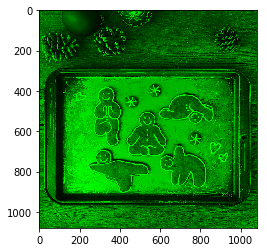

In [48]:
plt.imshow(img)

In [35]:
import matplotlib.pyplot as plt

In [65]:
np.percentile(img[0], (5, 95)).range()

AttributeError: 'numpy.ndarray' object has no attribute 'range'